# Select wildfire burn area predictors & make future predicitons. 

### This will be done using Laso 

This notebook will be used to see how laso selection works. I am going to see what met predictors work best at accounting for wildfire burn area for each grid box. I am going to insert random nonsense into the predictor matrix as a way to test that I know what laso is doing and to ensure that these random predictors are discarded... If they are not, then these methods do not work as I understan or hoped. 

Show predicted values vs actual for the data used to create the model and the data I set aside. 

Use every environmental variable available as a predictor (e.g. T, Tp, RH, ScfWind, VPD, ...), then, create lagged versions of these data as predictors as well. For example, shift the environmental arrays by minus one month, so that the month before the burn area occurs is used as the predictor. Do this for different time lags. Do this the other way too to help determine the validity of our methods. If temperature 5 months after a wildfire is the best predictor of wildfire occurrence, the model is doing something that can not represent an actual environmental predictor. 

#### TODO: 
* Make sure all sklearn models use numpy arrays not pd.DataFrames



In [1]:
# Import needed libraries and paths to local fire and Met Data
import numpy as np
from netCDF4 import Dataset
import os
%matplotlib inline
# For higher resolution figures
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, Lasso, LinearRegression
from sklearn import datasets
import time
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
# Modules I have written 
import model_dictionary as md # md, you know, like the helpful kind of doctor
import random

from sklearn import preprocessing # For scaling data 

import met_spread_utils as utils

In [2]:
# Set the spatial domain of analysis:

if False : 
    # Western U.S. 
    minX=235.
    maxX=258.
    minY=31.
    maxY=49.

minX=240. 
maxX=258.
minY=40. 
maxY=50.

### In our work, we are interested in predicting total summer burn area. 

#### Lets start by selecting the best predictors for June, July, August burn area

In [3]:
# Get the values we need to predict, a target, in this projectburn area. This is the target. 
# We want to estimate the unknown target function. 
def get_FPA_FOD_nc_data(minX=235., maxX=258., minY=31., maxY=49.) :
    """
    Loads FPA FOD burn area nc data into the workspace. The specific 
    file loaded is 'FPA_FOD_monthly_1992_2015_with_LC_COMMON_GRID.nc'.
    
    
    Parameters
    ----------

    minX : float, min longitude (0-360) of the data to return. 
    maxX : float, max longitude (0-360) of the data to return. 
    minY : float, min latitude of the data to return. 
    maxY : float, max latitude of the data to return. 
    
    Return
    ----------
    Arrays:
        Burn_area [m**2] (t,lat,lon,land cover), time, lon, lat, land_cover
    
    TODO: Move to support class. 
    """
    
    burnFile = os.path.join("..", "Data", "Fire", "FPA_FOD", 'FPA_FOD_monthly_1992_2015_with_LC_COMMON_GRID.nc')
    nc = Dataset(burnFile, 'r')
    BA = nc.variables['burn_area'][:]
    t = nc.variables['time'][:]
    LC = nc.variables['LC'][:]
    x = nc.variables['lon'][:]
    y = nc.variables['lat'][:]
    nc.close()

    # Get an array to allow easy subsetting of time
    t_fire = pd.date_range("1992-01-01", periods=len(t), freq="M")

    # Spatially subset these data to the western US 
    lonIndex = np.where( ( (x >= minX) & (x <= maxX)) )[0]
    latIndex = np.where( ( (y >= minY) & (y <= maxY) ) )[0]
    timeIndex = range(BA.shape[0]) # dummy index to retain all time dimensions
    LC_index = range(len(LC))
    
    x_subset = x[lonIndex]
    y_subset = y[latIndex]
    BA_subset = BA[np.ix_(timeIndex, latIndex, lonIndex, LC_index)]
    
    return BA_subset, t_fire, x_subset, y_subset, LC 

#### Visualize total burn area and seperate by land cover type for lasso regression

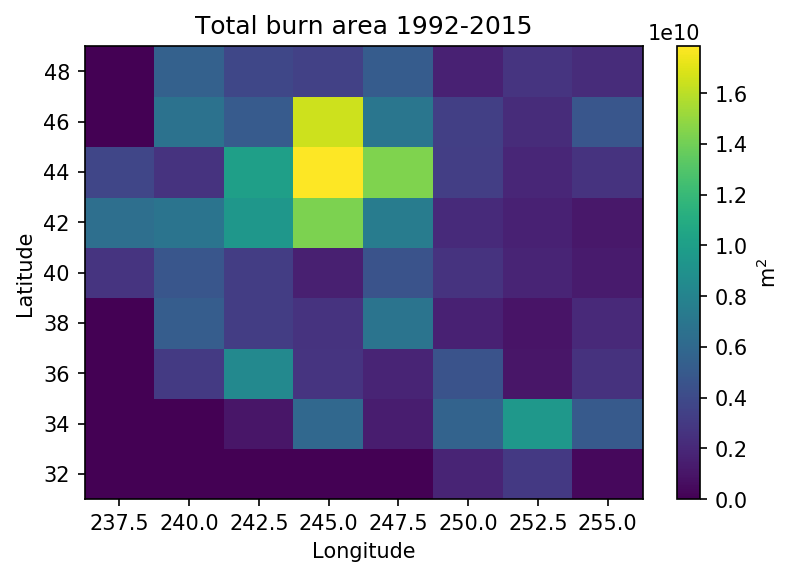

In [4]:
# Get the gridded FPA FOD burn area data [time, lat, lon, LC]
BA, t_fire, lon, lat, LC  = get_FPA_FOD_nc_data(minX, maxX, minY, maxY)

# TODO: SHOW STATES 

plt.figure(dpi=150)
plt.pcolor(lon, lat, np.sum(BA, axis=(0, 3)))
plt.colorbar(label="m$^{2}$")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Total burn area 1992-2015")
plt.show()

### Subset BA array by land cover categories of interest. 
https://landcover.usgs.gov/global_climatology.php
* TODO: It is probably ok/needed to combine shrubs and grass. 

In [5]:
LC_category_dict = {
    "all"    : [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
    "forest" : [1,2,3,4,5],
    "shrubs" : [6,7],
    "grass"  : [10] 
}

# Create a dictionary that will store the total burn area for these
# land cover categories. 
BA_dict = {}
for lc in LC_category_dict.keys() :
    
    # BA[t, lat, lon, LC]
    BA_dict[lc] = BA[:,:,:, LC_category_dict[lc] ]
    print(lc, BA_dict[lc].shape)
    
if False :   
    plt.figure(dpi=150)
    plt.pcolor(lon, lat, np.sum(BA_dict["shrubs"], axis=(0, 3)))
    plt.colorbar(label="m$^{2}$")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Total shrub burn area 1992-2015, all months, all ignitions")
    plt.show()

('all', (288, 10, 9, 17))
('grass', (288, 10, 9, 1))
('forest', (288, 10, 9, 5))
('shrubs', (288, 10, 9, 2))


#### Sum burn area for land cover types of interest in the loaded domain.
* Transforms gridded burn area data into array of monthly totals for the domain for land covers of interest. 

In [6]:
# Sum the burn area in the chosen domain 
BA_monthly_dict = {}
for lc in BA_dict.keys() : 
    # BA_dict[land_cover].shape = [t, lat, lon, LC]
    BA_monthly_dict[lc] = np.sum(BA_dict[lc], axis=(1,2,3))
    print(lc, BA_monthly_dict[lc].shape)

('all', (288,))
('grass', (288,))
('forest', (288,))
('shrubs', (288,))


#### Show the time series of these data. 

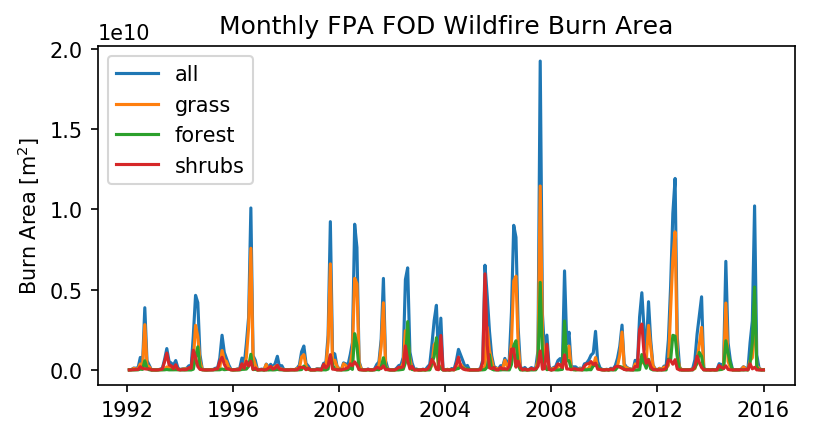

In [7]:
plt.figure(figsize=(6,3), dpi=150)
for lc in BA_monthly_dict.keys() :
    plt.plot(t_fire, BA_monthly_dict[lc], label=lc) 
plt.legend()
plt.ylabel("Burn Area [m$^{2}$]")
plt.title("Monthly FPA FOD Wildfire Burn Area")
plt.show()

### Make sure total is a sum of the parts and that burn area is not lost or gained...
* all includes more land cover types than are included in the types plotted here. Make sure you can close the budget. 

#### Create a function for loading corresponding era-interim data

In [8]:
# Get era-interim nc data entire western US spatial averages 
# TODO: replace with call to this function in the utils script
def get_era_nc_vals(var="t2m", minX=235., maxX=258., minY=31., maxY=49., spatialMean=False, startYear=1992):
    """
    This function will be for loading a particular nc file, which will be spatially subset.
    The data loaded are from the merged_t_COMMON_GRID directory. These data have been
    regridded from thier native resolution using cdo remapbil. 
    
    # TODO: Move to class. 
    
    Parameters
    ----------

    var : str, The variable (and file name) of the ECMWF era-interim data to be 
          loaded. 
    minX : float, min longitude (0-360) of the data to return. 
    maxX : float, max longitude (0-360) of the data to return. 
    minY : float, min latitude of the data to return. 
    maxY : float, max latitude of the data to return. 
    
    spatialMean : Boolean, if False (default) a spatial mean of the era-interim data
                  is not taken and the data are returned on a t,lon,lat grid. 
                  
    Return
    ------
    valsCut : The chosen "var" as a ndarray(t, lat, lon) or if spatialMean = True
              ndarray(t). 
    t_monCut : pd.date_range describing the t axis of valsCut. 
    lonCut : longitude ndarray
    latCut : latitude ndarray
    
    """
    
    # Create link to the monthly file
    dataDir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
    f = var + "_1990-2015.nc" 

    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! 
    if(not os.path.isfile(loadFile)):
        raise ValueError(f + " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 312):
        # Convert to pandas time array, on the assumption t[0]=1990-01-01 and t[-1]=2015-12-01
        # 26 years times 12 months per year makes for 312 months expected in these arrays
        t_mon = pd.date_range("1990-01-01", periods=len(t), freq="M")
    else:
        # there should always be 312 months in these data (26 years of data)
        raise ValueError('Error in number of months for file: '+ f + " 312 expected.")
        
    # Now subset the data based on the passed max and min values for lon and lat
    lonIndex = np.where( ((lon >= minX) & (lon <= maxX)) )[0]
    latIndex = np.where( ( (lat >= minY) & (lat <= maxY) ) )[0]
    
    # Where is the first month of startYear
    t_first = np.where(t_mon.year == startYear)[0][0]
    
    # because we want all months, for now, but starting in startYear
    timeIndex = range(t_first, len(t)) 

    # Subset the 2D field
    lonCut = lon[lonIndex]
    latCut = lat[latIndex]
    t_monCut = t_mon[timeIndex]

    # Subset the 3D field
    valsCut = vals[np.ix_(timeIndex, latIndex, lonIndex)]

    # take a spatial mean? 
    if spatialMean:
        valsCut = np.mean(valsCut, axis=(1,2))
    
    return valsCut, t_monCut, lonCut, latCut

In [9]:
# TODO: Replaces with sklearn functionality or move to utils script

def scale_one_one(X) :
    """
    Function takes a pandas dataframe and scales each column of the
    dataframe to be between -1 and 1.
    
    Parameters
    ----------
    X : pandas.DataFrame, where the columns are features to be 
        rescaled to min=-1. and max = 1.
    
    """
    X_prime = (2.*X - np.max(X) - np.min(X))/(np.max(X) - np.min(X))
    
    return X_prime

def standardize_era(X):
    """
    Function takes a pandas.DataFrame and converts it to units of 1/sigma
    with mean=0. Also, gets the mean and variance of model output and stores
    for later use. I.e. accepts a pandas DataFrame and finds
    the mean and variance for each column. 
    """
    
    # The historical mean value is needed to standardize the CMIP5 values.
    X_means  = X.mean()
    # The historical standard deviation is needed to standardize the CMIP5 values. 
    X_std    = X.std()
    
    # TODO: MAKE SURE THAT THIS IS STANDARIZING FEATURES, NOT EXAMPLES
    Z_matrix = preprocessing.scale(np.array(X.copy()), axis=0)
    Z_df     = pd.DataFrame(Z_matrix, columns=X.columns, index=np.array(X.index.values.copy()))
    
    return Z_df, X_means, X_std


#### Load desired ERA-Interim reanalysis features and place in df.
* Update to include soil moisture and evaporation when needed? 

In [10]:
predictors = ["t2m", "tp", "si10", "RH", "ssrd", "VPD"] # aka features 
predictorDict = {}
for var in predictors:
    
    predictorDict[var], t, lon, lat = get_era_nc_vals(var=var, 
                                                      minX=minX, maxX=maxX, minY=minY, maxY=maxY,
                                                      spatialMean=True,
                                                      startYear=1992)

# Features used to estimate the target function    
X_monthly = pd.DataFrame(predictorDict)


Change units of era-precipitation (tp) field. 

All units matchthose of CMIP5 except tp (total precipitation) field from ecmwf, which are stored as m mon$^{-1}$. Convert to $kgm^{-2}s^{-1}$ with the following equation. 

$$tp^{'} = tp(\frac{m}{mon})\times1000(\frac{kg}{m^{3}})\times\frac{1mon}{30day}\times\frac{1day}{86400s}$$

In [11]:
def m_to_mass_flux(tp_m) :
    """
    This function takes total precipitation in meters [m] and converts to a mass flux. 
    Incoming tp_m argument must have units of m/mon. Multiplication by the density
    of water, 1 mon per 30 days, 1 day per 86400 seconds are used to obtain units
    of kg m**-2 s**-1, the so-called tp_prime value that is returned. 
    """
    density = 1000. # kg m**-3
    monPerDay = 1./30. # mon day**-1
    dayPerSecond = 1./86400. # day second**-1
    tp_prime = tp_m * density * monPerDay * dayPerSecond 
    
    return tp_prime

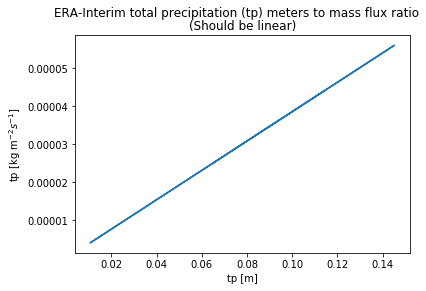

In [12]:
tp_mass_flux = m_to_mass_flux(tp_m = np.array(X_monthly["tp"]) )

plt.figure()
plt.plot(X_monthly["tp"].values, tp_mass_flux)
plt.xlabel("tp [m]")
plt.ylabel("tp [kg m$^{-2}s^{-1}$]")
plt.suptitle("ERA-Interim total precipitation (tp) meters to mass flux ratio")
plt.title("(Should be linear)")
plt.show()

# Replace m to with mass flux version. 
X_monthly.loc[:, "tp"] = tp_mass_flux

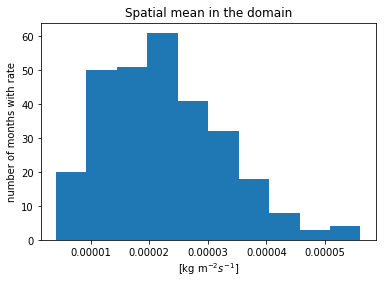

In [13]:
plt.figure()
plt.hist(tp_mass_flux)
plt.xlabel("[kg m$^{-2}s^{-1}$]")
plt.title("Spatial mean in the domain")
plt.ylabel("number of months with rate")
plt.show()

### Setup summer forecasting using seasonal (varying t-lag) predictors

##### Predictors (aka features)
- summer, spring, winter,  temperature
-  ...

# TODO: Ths needs to be a function that will work the same way for CMIP5 data 

In [14]:
# Create summer burn area time series
years  = np.sort(np.unique(t_fire.year))
nYears = len(years)
BA_summer_dict = {}
for lc in BA_monthly_dict.keys():
    BA_summer_dict[lc] = np.zeros(nYears)

# Create season masks (first month last month of season). Each season gets its own 
# column in the features DataFrame.
# NOTE: Make sure to not use months after wildfires in a given year, e.g. 
# NOTE: December, unless set to the year before # Make sure to not use months 
# NOTE: after wildfires in a given year, e.g. December, unless set to the year before 
month = pd.Series(t.month)
seasons = {"winter":[1,2], 
           "spring":[3,4,5], 
           "summer":[6,7,8]}

# Make a dictionary to store predictors for each variable for each season 
# of interest. 
# TODO: Nino-index as a predictor? 
variables = ["t2m", "tp", "si10", "RH", "VPD"]
predictor_dict = {} # To store predictor information 
for pre in variables:
    for s in seasons.keys():
        predictor_name = pre + "_" + s 
        predictor_dict[predictor_name] = np.zeros(nYears)
        
# Loop through each year, assigning desired season predictor value 
# within each year 
for i in range(nYears):
        
    # Mask the year of interest, 0 through nYears  
    year_mask = years[i] == t.year
    
    # Loop through seasons, within a year
    for s in seasons.keys():
        
        # Mask the months that fall into the current season of interest
        month_mask = month.isin(seasons[s])

        # combine to make a single mask
        tChunk = month_mask & year_mask 

        # Take desired stats (mean or sum) of these temporal chunk
        if s == "summer":
            for lc in BA_summer_dict.keys() :
                BA_summer_dict[lc][i] = np.sum(BA_monthly_dict[lc][tChunk])
            #print(t[tChunk])

        # For each predictor variable, loop through taking relevant stat
        # TODO: consider an if statement to take sums vs. means of variables
        # TODO: See if .loc is better for subsetting DataFrame X
        for pre in variables:
            predictor_dict[pre+"_"+s][i] = np.mean(X_monthly.loc[tChunk, pre])
    
# Assign the summer values to a Features DataFrame. Here, I switch
# to some more math-ish language. 
df_features = pd.DataFrame(predictor_dict, index=years)
df_targets  = pd.DataFrame(BA_summer_dict, index=years)
    
# New better name
era_df_features = df_features.copy()
    
# This is now a nice Dataframe, so we can get rid of the outdated dict. 
del predictor_dict, BA_summer_dict, df_features

era_years = years

era_df_features

RH_spring  RH_summer  RH_winter  VPD_spring   VPD_summer  VPD_winter  \
1992  54.734577  49.136963  68.879433  684.585876  1270.313843  265.452850   
1993  57.800262  51.937302  73.493576  627.556396  1160.774292  202.872208   
1994  54.212261  42.837387  65.011749  664.466309  1597.918945  291.579071   
1995  59.740894  48.444393  71.092545  536.288513  1331.001099  257.056061   
1996  55.260162  44.628124  66.311172  674.587891  1506.671753  292.951874   
1997  55.090042  50.239807  69.539825  658.488098  1285.565063  255.114075   
1998  58.789459  49.730671  72.415176  555.822021  1343.200317  236.722763   
1999  54.927368  49.836201  64.563728  596.845215  1255.455444  322.131531   
2000  53.400497  44.973385  67.153313  718.928650  1490.281616  303.860901   
2001  54.604939  46.179352  69.114670  688.120300  1457.558716  243.032745   
2002  52.066254  44.271488  62.506077  682.303589  1537.747559  310.604858   
2003  55.730885  44.244678  68.610306  641.357605  1572.723511  286.134460   
2004  53.103786  48.101093  68.911163  706.230774  1349.007935  249.477875   
2005  55.378174  46.960896  71.338737  628.682678  1417.806519  235.671326   
2006  52.326965  44.893921  58.922028  721.396484  1533.448242  365.790253   
2007  51.906780  44.048489  64.951126  711.199402  1565.201050  280.157074   
2008  49.070988  44.745556  65.493553  690.154602  1470.843384  273.309265   
2009  50.835125  46.903500  62.554787  715.530762  1395.339233  328.109436   
2010  53.830383  47.741211  71.136398  605.710388  1378.671997  236.345993   
2011  55.224224  46.073574  63.463684  628.973206  1472.938354  285.036194   
2012  48.326721  43.516338  60.700211  788.020020  1585.006470  335.326416   
2013  50.147659  46.428116  63.963394  736.922058  1492.387085  282.152100   
2014  49.709431  47.797588  60.881874  737.570984  1394.125000  353.954376   
2015  52.857227  46.228443  66.939270  677.313049  1480.758789  322.623474   

      si10_spring  si10_summer  si10_winter  t2m_spring  t2m_summer  \
1992     3.520319     3.412460     3.448933  284.850956  292.791312   
1993     3.776189     3.747155     3.607503  283.756721  291.713784   
1994     3.746788     3.537000     3.624164  284.007009  294.150171   
1995     3.973573     3.542757     3.545817  282.219268  292.716497   
1996     4.069425     3.512201     3.906711  282.916964  293.844979   
1997     3.951455     3.489796     3.774096  283.210345  293.081468   
1998     3.734655     3.390273     3.827474  282.316378  293.330429   
1999     4.175553     3.535664     4.086343  282.252972  292.578373   
2000     3.970275     3.513611     3.659203  283.969485  293.748776   
2001     3.824206     3.428852     3.501377  283.567592  293.654859   
2002     3.961892     3.505652     3.708927  282.198806  293.870362   
2003     3.943707     3.387379     3.362360  283.169687  294.436817   
2004     3.914555     3.384099     3.517057  284.366088  293.088915   
2005     3.954814     3.500226     3.291542  283.452106  293.316397   
2006     3.945512     3.326064     3.881213  283.583566  294.325844   
2007     3.847403     3.462313     3.803401  283.996209  294.336801   
2008     4.194224     3.546160     3.940149  282.377025  293.389030   
2009     4.076238     3.305647     3.704813  283.069988  293.074747   
2010     4.232440     3.554942     3.349536  282.374195  293.019617   
2011     4.361014     3.553347     3.814416  282.228450  293.407193   
2012     4.217094     3.514919     3.825926  284.296013  294.220809   
2013     3.984825     3.325752     3.661741  283.427163  294.155053   
2014     4.060435     3.358184     3.728866  283.639810  293.528326   
2015     3.689157     3.262352     3.334449  284.152379  294.480338   

      t2m_winter  tp_spring  tp_summer  tp_winter  
1992  276.664905   0.000026   0.000021   0.000029  
1993  273.441800   0.000030   0.000026   0.000041  
1994  274.957671   0.000022   0.000010   0.000027  
1995  276.877579   0.000038   0.000019   0.000038  
1996  275.367196   

In [15]:
df_targets

all        forest         grass        shrubs
1992  5.052982e+09  6.605290e+08  3.391091e+09  3.655759e+08
1993  2.289474e+09  4.294367e+07  4.650978e+08  1.624682e+09
1994  1.096861e+10  2.278143e+09  5.442168e+09  2.235195e+09
1995  3.995167e+09  9.215256e+07  1.956055e+09  1.688380e+09
1996  1.500907e+10  1.260473e+09  1.101267e+10  1.335729e+09
1997  1.409458e+09  4.968792e+07  5.726453e+08  4.649126e+08
1998  2.934300e+09  2.814929e+08  1.880561e+09  4.757960e+08
1999  1.180039e+10  9.810007e+08  8.522690e+09  1.355808e+09
2000  1.841444e+10  3.823597e+09  1.232221e+10  1.086339e+09
2001  8.114252e+09  9.569861e+08  5.915006e+09  4.600337e+08
2002  1.310437e+10  3.710013e+09  5.110926e+09  2.148041e+09
2003  8.688321e+09  3.295991e+09  3.559538e+09  1.125091e+09
2004  2.760349e+09  4.079505e+08  7.120223e+08  1.075817e+09
2005  1.352820e+10  1.164628e+09  4.091598e+09  7.653086e+09
2006  2.089250e+10  3.682601e+09  1.306253e+10  2.785137e+09
2007  2.388594e+10  6.669953e+09  1.431685e+10  1.445529e+09
2008  1.014849e+10  4.193839e+09  2.977662e+09  1.053434e+09
2009  4.385056e+09  5.677512e+08  1.374367e+09  1.287428e+09
2010  4.991717e+09  5.710163e+08  3.542899e+09  5.198407e+08
2011  8.094203e+09  1.228303e+09  4.263793e+09  2.124868e+09
2012  2.685168e+10  4.861352e+09  1.926245e+10  1.586309e+09
2013  1.018333e+10  2.360174e+09  4.898895e+09  1.475980e+09
2014  8.856231e+09  2.941310e+09  4.859054e+09  3.924029e+08
2015  1.496678e+10  7.279499e+09  5.443555e+09  6.166881e+08

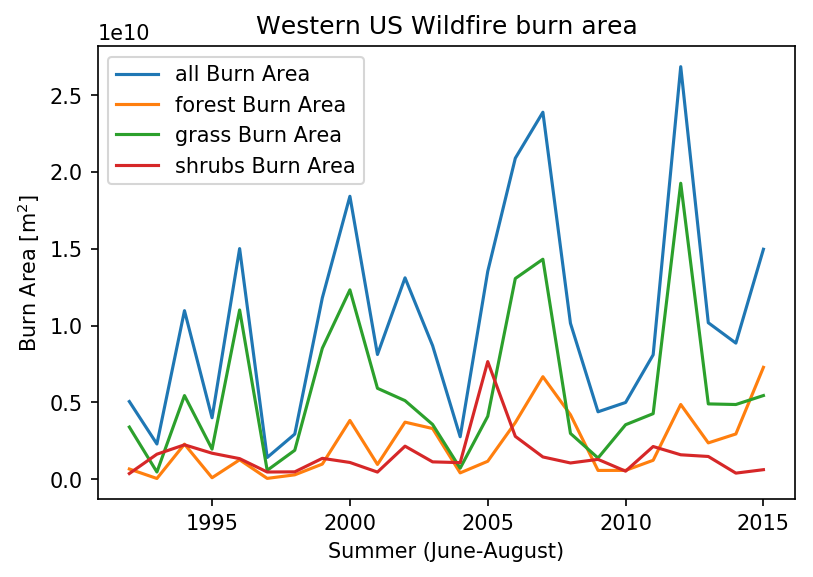

In [16]:
plt.figure(dpi=150., figsize=(6,4))
for target in df_targets.columns :
    plt.plot(era_years, df_targets[target], label=target + " Burn Area")
plt.title("Western US Wildfire burn area")
plt.ylabel("Burn Area [m$^{2}$]")
plt.xlabel("Summer (June-August)")
plt.legend(loc="best")
plt.show()

For western U.S. as a whole, the 2005 shrub burn area year, due to the HUMBOLDT fire which was part of the Cave Creek Complex, was VERY high and makes it such that no linear model works. Replace 2005 shrub burn area with an average year burn area value. 

In [17]:
print("Original 2005 burn area that makes linear model not possible: ")
print(df_targets.loc[2005, "shrubs"])

Original 2005 burn area that makes linear model not possible: 
7653086208.0


In [18]:
# np.array() required so that this is not just a reference 
shrub_BA_original = np.array(df_targets["shrubs"]) 
mean_BA = np.mean(shrub_BA_original)
# Change the 2005 value 
df_targets.loc[2005, "shrubs"] = mean_BA

print("New 2005 burn area that makes linear model possible: ")
print(df_targets.loc[2005, "shrubs"])

New 2005 burn area that makes linear model possible: 
1515921000.0


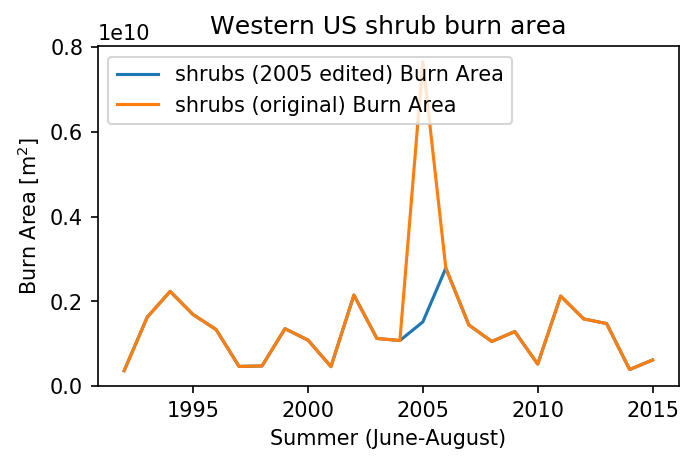

In [19]:
plt.figure(dpi=150., figsize=(5,3))
plt.plot(era_years, df_targets["shrubs"], label="shrubs (2005 edited)" + " Burn Area")
plt.plot(era_years, shrub_BA_original, label="shrubs (original)" + " Burn Area")
plt.title("Western US shrub burn area")
plt.ylabel("Burn Area [m$^{2}$]")
plt.xlabel("Summer (June-August)")
plt.legend(loc=2)
plt.show()

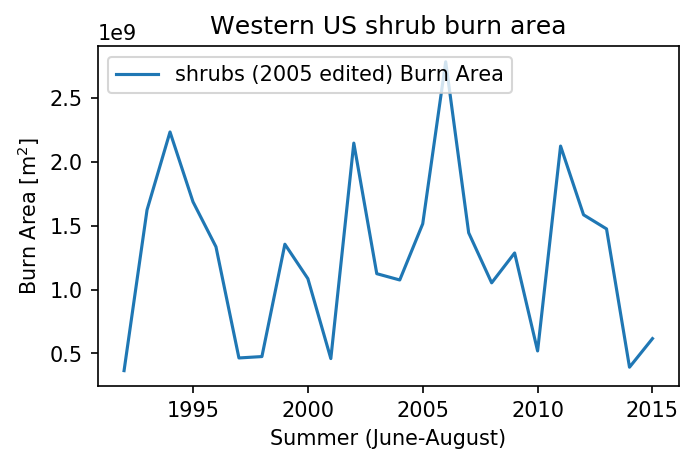

In [20]:
plt.figure(dpi=150., figsize=(5,3))
plt.plot(era_years, df_targets["shrubs"], label="shrubs (2005 edited)" + " Burn Area")
plt.title("Western US shrub burn area")
plt.ylabel("Burn Area [m$^{2}$]")
plt.xlabel("Summer (June-August)")
plt.legend(loc=2)
plt.show()

#### Standardize the features for summer burn area prediction

In [21]:
def plot_coefs(target, model, X) :
    """
    A function for plotting the coefs found by the regression. 
    Must be embedded in a figure. 
    
    Parameters
    ----------
    target : The variable being predicted, as a signle column pd.DataFrame. 
    model : an instance of a Lasso model class. 
    X : The features used to predict the target in the model. 
    
    """
    
    plt.bar(x=X.columns.values, height=model.coef_)
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coef")
    plt.title(target + " land cover burn area predictors, $\\alpha$=" + str(np.round(model.alpha_,5)))

#### Use out of the box, LassoCV for desired targets. 
* Are the coeficients different for different land cover values within the same spatial domain ($i.e.$) exact same predictor features
* Coefficients represent relative importance in the model.
* Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. Alpha = 0 is OLS regression. 

#### How consisten are these coeficients with existing literature??

"Here, the key fact about LASSO regression is that it minimizes sum of squared error, under the constraint that the sum of absolute values of coefficients is less than some constant c. (See here.) So, for all of the coefficients to be zero, there must be no vector of coefficients with summed absolute value less than c that improves error."

### Implement a custom cross validation scheme that minimizes out of sample square error
* Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. When alpha = 0 Lasso is the same as OLS regression. 

for alpha value in a range

    for leaving a year out: (1992:2015):
        
        leave_one_out_model = Lasso(alpha, these years of targets and predictors)
        save mean square error
        save the coefs
     
     Calculate mean error for this alpha
     
The square error for all years left out for a given alpha are calculated as follows:

$$RMSE(h) = \sqrt{\frac{1}{N}\sum_{i=1}^N (y_i - h(\mathbf{x}_i))^2}$$

### TODO: Implement internal cross validation! Use sklearn instead of this custom implementation. 

In [22]:
# TODO: use sklearn.model_selection.LeaveOneOut.html
# TODO: and param grid search to find the best classifier. 

def leave_one_year_out_cv(y, Z, years, alphas):
    """
    Function for finding the Lasso alpha value that minimizes the square error
    on the year left out of lasso regression model estimation.
    
    Parameters
    ----------
    y : ndarray, the target being estimated by scikit_learn.Lasso()
    Z : pd.DataFrame with features to predict y. Same number of rows as 
        the length of y. 
    years : The years to loop over, correspond to rows Z and indicies in y. 
            In the year loop, each year will be left out and predicted on. 
    alphas : The alpha values to loop over and keep track of out of sample
             error. 
             
    return
    ------
    alpha_mean_error, min_error_row, alpha_best, error_df
    
    """
    
    # Keep track of the out of sample error for the left out year
    # whos burn area is predicted. 
    error_df = pd.DataFrame(index=alphas, columns=years)

    for alpha in alphas:
        # The "year" is the year that is left out of the features
        # and is predicted. It is what I use to estimate the out
        # of sample error. 
        for year in years:

            # Mask out this year of data and make the model without it. 
            test_year_mask = pd.Series(years).isin([year])
            test_year = np.array(years[test_year_mask])
            training_years_mask = [not i for i in test_year_mask]
            
            if False : 
                print(test_year_mask)
                print(test_year)
                print("Training Years")
                print(years[training_years_mask])

            # Get rid of year from the features and target
            Z_subset = Z.loc[training_years_mask,:]
            y_subset = y[training_years_mask]
           
            if False :
                print("training data subset")
                print(Z_subset.shape)
                print(y_subset.shape)

            # Make an instance of the Lasso class and create a fit(). 
            model = Lasso(alpha=alpha).fit(Z_subset.values, y_subset)
            
            # Use the model to predict values for the year left out of the model
            # i.e. use the coefs to guess the left out year. 
            LOO_pred_Z = np.array(Z.loc[test_year, :].copy())
            predicted_value = model.predict(LOO_pred_Z)
            
            # Calculate the square error of the year left out. 
            square_error = (predicted_value - y[test_year_mask])**2
            if False :
                print("Predicted value shape")
                print(predicted_value.shape)
                print(square_error)

            # Store the error of the model 
            error_df.at[alpha, year] = square_error

    # Take the mean error of each row 
    alpha_mean_error = error_df.mean(axis=1)
    min_error_row    = np.argmin(alpha_mean_error.values)
    alpha_best       = alphas[min_error_row]
    
    return alpha_mean_error, min_error_row, alpha_best, error_df 

#### Create an alpha range to span and calculate error associated with estimating year left out. 
- Research what you want these curves to look like in terms of performance from first principles. 
- TODO: Make all cross validation methods into a class. 

Finding alpha for all lands


/Users/sbrey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/sbrey/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/sbrey/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha best: 0.047
Finding alpha for forest lands
alpha best: 0.023
Finding alpha for grass lands
alpha best: 0.068
Finding alpha for shrubs lands
alpha best: 0.137


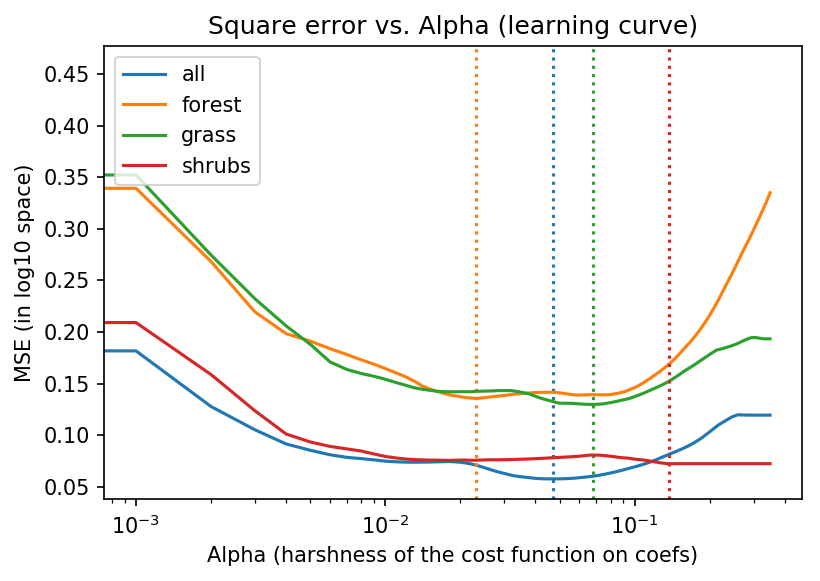

In [23]:
# Standardize the historical features that will train the linear model. 
# NOTE: Future features from CMIP5 MUST be standardized using these same
# NOTE: means and variance values for trends and changes to occur in future
# NOTE: estimates. 
Z, X_reference_means, X_reference_std = standardize_era(era_df_features)

# Alphas to make models for
alphas = np.arange(0., 0.35, 0.001)

# Tableau color pallete. 
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

alpha_error_dict = {}
alpha_CV_dict = {}
plt.figure(dpi=150)
i = 0
for target in df_targets.keys() :
    
    print("Finding alpha for "+ target + " lands")
    
    # Get the target- log10 transformed
    y = np.log10(df_targets[target].copy().values)
    #print(y)
    alpha_mean_error, min_error_row, alpha_best, error_df = leave_one_year_out_cv(y, Z, years, alphas)
    
    # Save the alpha that had the minimim square error
    alpha_CV_dict[target] = alpha_best
    alpha_error_dict[target] = error_df
    
    print("alpha best: " + str(alpha_best) )
    
    # Show the error and location of best alpha 
    plt.semilogx(alphas, alpha_mean_error, c=line_colors[i], label=target)
    plt.axvline(x=alpha_best, c=line_colors[i], linestyle=":")
    i+=1         
        
plt.xlabel("Alpha (harshness of the cost function on coefs)")
plt.ylabel("MSE (in log10 space)")
plt.title("Square error vs. Alpha (learning curve)")
plt.legend(loc=2)
plt.show()

When a curve slowley tapers downwards that means that the mean square error is smallest when there are no coeficeitns and a constand value is guess. i.e. zero learning. Not good? Definitly not a stable solution. 

### I do not have an intuition for how this should look 
* However, it does seem that years with very high errors compared to others are driving the selection of $\alpha$, while normal looking years contribute roughly evenly. 

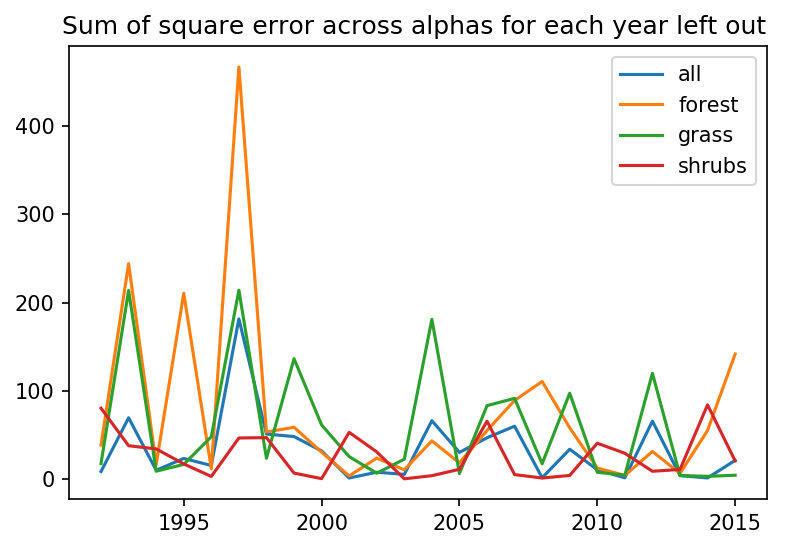

In [24]:
plt.figure(dpi=150)
alpha_error_dict["all"].sum().plot(title="square error", label="all")
alpha_error_dict["forest"].sum().plot(title="square error", label="forest")
alpha_error_dict["grass"].sum().plot(title="square error", label="grass")
alpha_error_dict["shrubs"].sum().plot(title="square error", label="shrubs")
plt.legend()
plt.title("Sum of square error across alphas for each year left out ")
plt.show()

In [25]:
def plot_alpha_year_error(E_dict=alpha_error_dict, alpha_dict=alpha_CV_dict, LC="all") : 
    
    df = E_dict[LC]
    
    # horizonal line
    y = alpha_dict[LC]

    # Make plotable arrays
    alphas = np.array(df.index.values, dtype=float)
    years = np.array(df.columns.values, dtype=float)
    E = np.array(df.values, dtype=float)

    plt.figure(dpi=150)
    plt.pcolor(years, alphas, E)
    plt.axhline(y=y, c="red")
    plt.colorbar()
    plt.xlabel("Year left out")
    plt.ylabel("alpha")
    plt.title(LC+" land cover $E_{out}$ square error")
    plt.show()

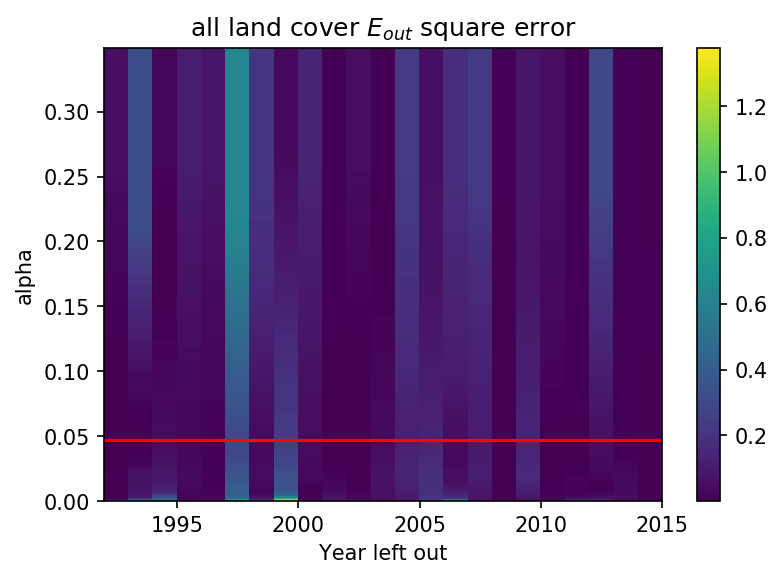

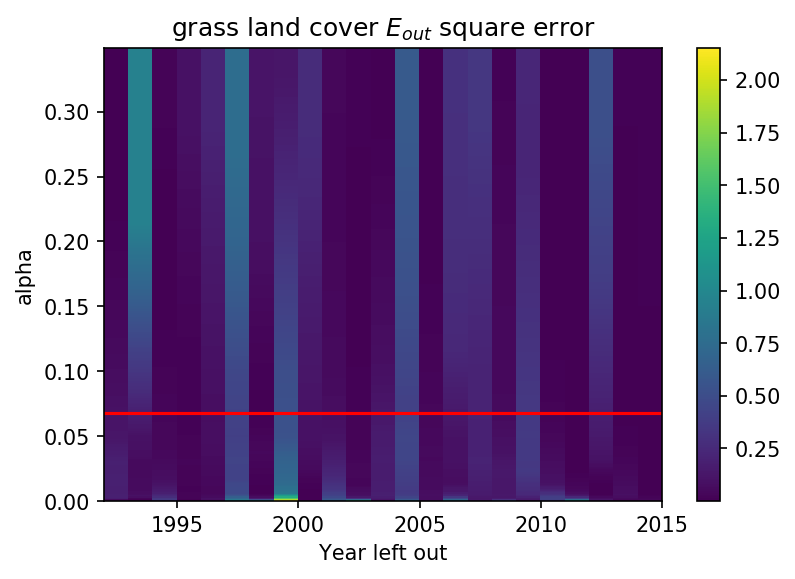

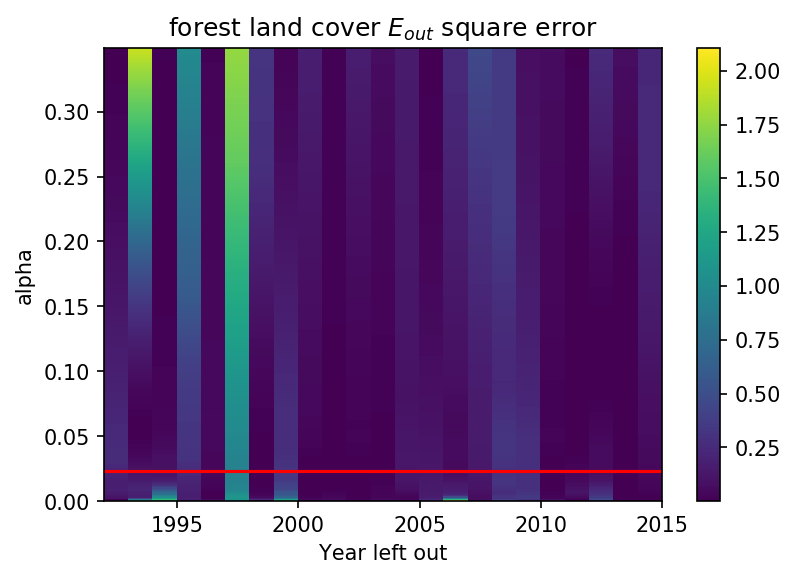

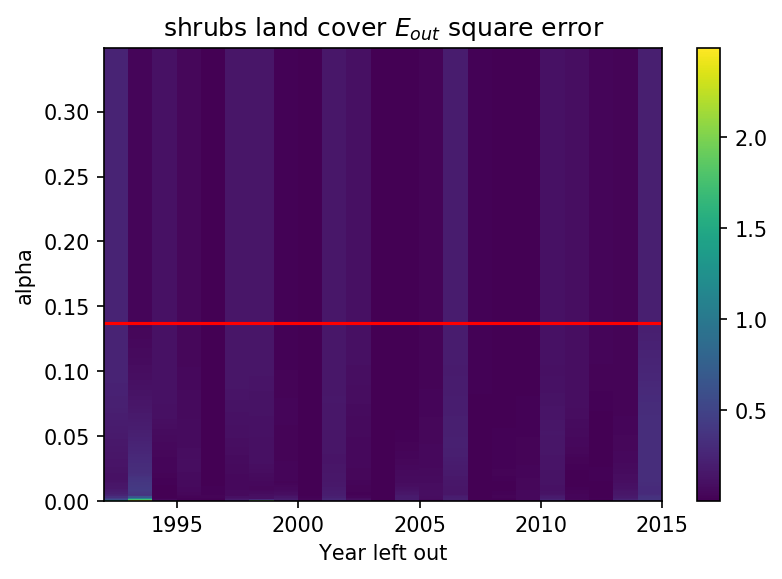

In [26]:
for LC in alpha_error_dict.keys() :
    plot_alpha_year_error(E_dict=alpha_error_dict, alpha_dict=alpha_CV_dict, LC=LC)

I was hoping this would have a much more obvious global minimum and maybe look something like a topograghic map. This pattern does not inspire confidense in my chosen alpha, the alpha that minumized out of sample error. 

In [27]:
def show_model_skill(target, y, Z, alpha_best, years) :
    """
    Predict historical values using optimal alphas.
    plots the following:
        1) model coeficients
        2) y vs. y_hat time series
        3) y vs. y_hat 1:1
        4) model residuals
        
        # TODO: Make into a class. 
        
    Parameters
    ----------
    target : The values being predicted as a pd.DataFrame
    y : the target values as an array
    Z : the features used to predict the target as a pd.DataFrame
    alpha_best : the alpha with the lowest leave_one_year_out_cv() out 
                 of sample error. 
    years : ndarray, the years the desribe rows of Z and indicies of y. 
    
    """
    
    # Using alpha best and predictors, create fit
    model_best = Lasso(alpha=alpha_best).fit(Z, y)
    
    # Make prediction
    y_hat = model_best.predict(Z)
    
    # Setup figure 
    fig = plt.figure(dpi=200, figsize=(10,10))
    
    fig.suptitle(target + " land cover regression summary", fontsize=14)
    
    ##########################################
    # Show the coeficients for the model_best
    ##########################################
    plt.subplot(2, 2, 1)
    #print(Z.columns.values)
    #print(model_best.coef_)
    plt.bar(Z.columns.values, model_best.coef_)
    plt.axhline(y=0, c="k", linestyle="--")
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coefficients")
    plt.title("Feature coefs for least square error model, $\\alpha$=" + str(np.round(model_best.alpha, 4)))

    ########################################
    # Plot obs and modeled values for both
    ########################################
    plt.subplot(2, 2, 2)
    r2 = np.round(metrics.r2_score(y_true=y, y_pred=y_hat),4)
    plt.plot(years, y, label="observation")
    plt.scatter(years, y, s=15)
    plt.plot(years, y_hat, label="model, r$^{2}$=" + str(r2), linestyle=":")
    plt.ylabel("log$_{10}$(burn area m$^{2}$)")
    plt.legend()
    plt.title("Time series of data and estimates")

    ########################################
    # Plot observations vs. modeled values
    ########################################
    x1 = np.linspace( np.min([y, y_hat]), np.max([y, y_hat]) )
    r = np.round(np.corrcoef(y, y_hat)[0][1], 3)

    plt.subplot(2, 2, 3)
    plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
    plt.scatter(y, y_hat, c=years)
    plt.xlabel("Observation")
    plt.ylabel("Predicted")
    plt.title("Observation vs. predicted values | r="+str(r))

    ########################################
    # Plot residuals 
    ########################################
    zero = np.zeros(len(years))
    
    plt.subplot(2, 2, 4)
    plt.scatter(years, y-y_hat, c=years)
    plt.plot(years, zero, color="k", linestyle=":")
    plt.ylabel("log$_{10}$(burn area m$^{2}$)")
    plt.title("Model residuals")
    plt.colorbar()
    
    plt.subplots_adjust(hspace=0.6)
    plt.show()

### Show the coeficients and performance of the best Lasso regressions
#### TODO:
* This is where it would make sense to save out these models, the coefs represent feature importance, here I can use these features and explicitly explore :

    1) The future variability/spread in the different important features
    
    2) The year a majority of CMIP5 models leave the range used to train the relationship

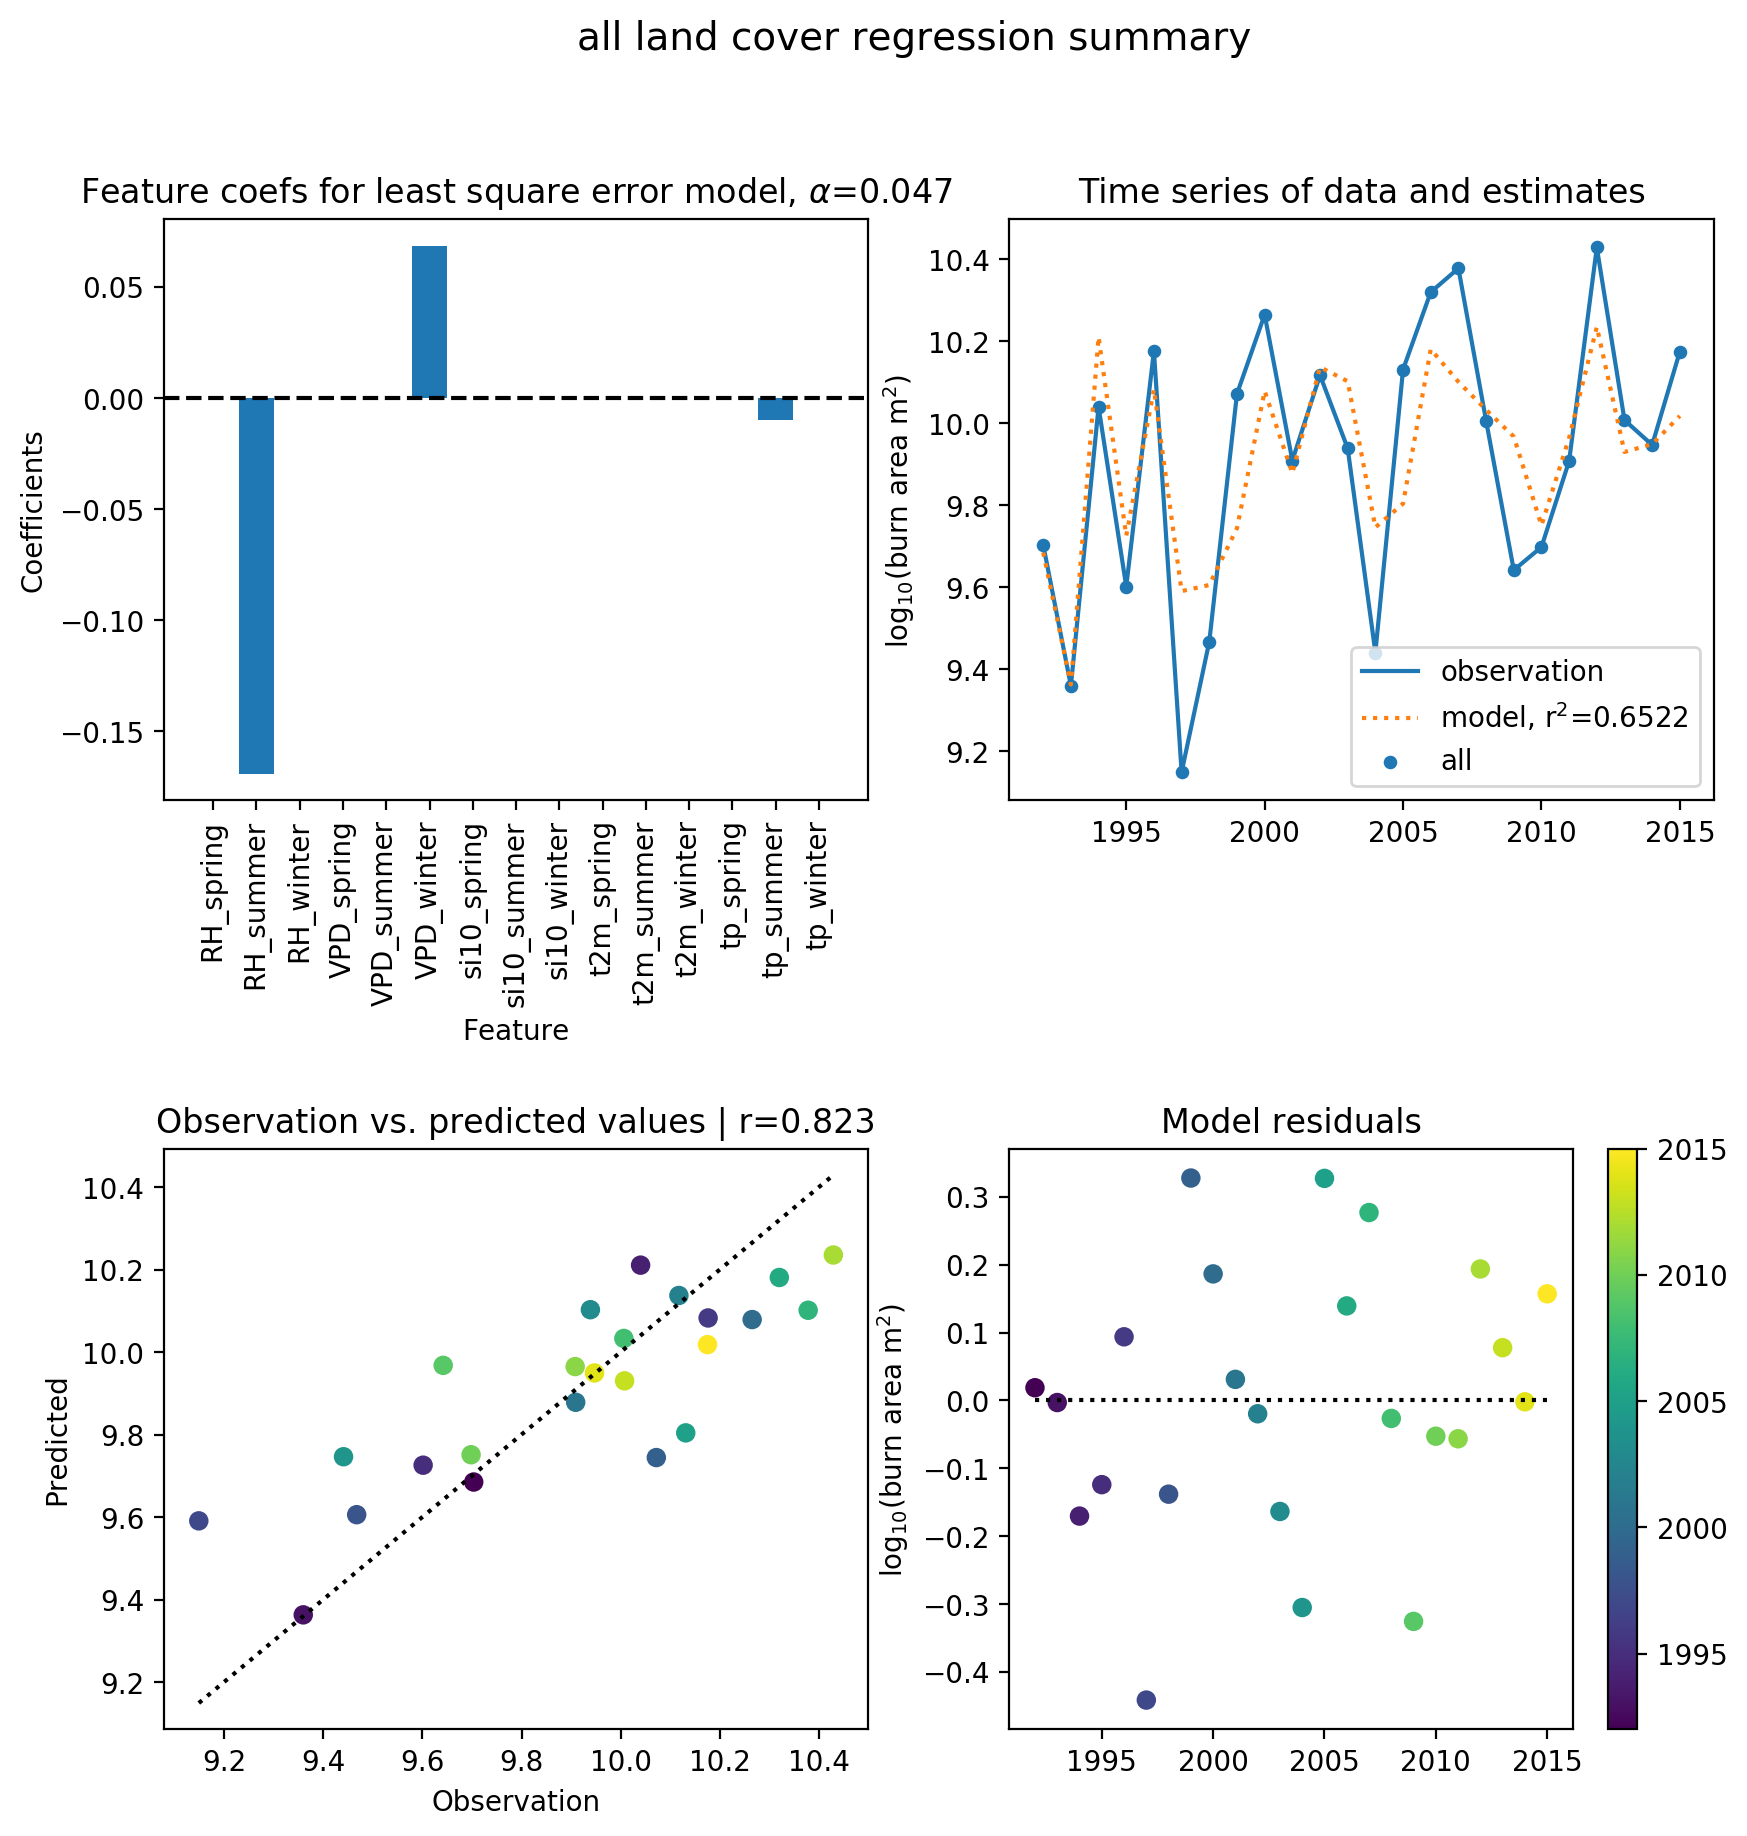

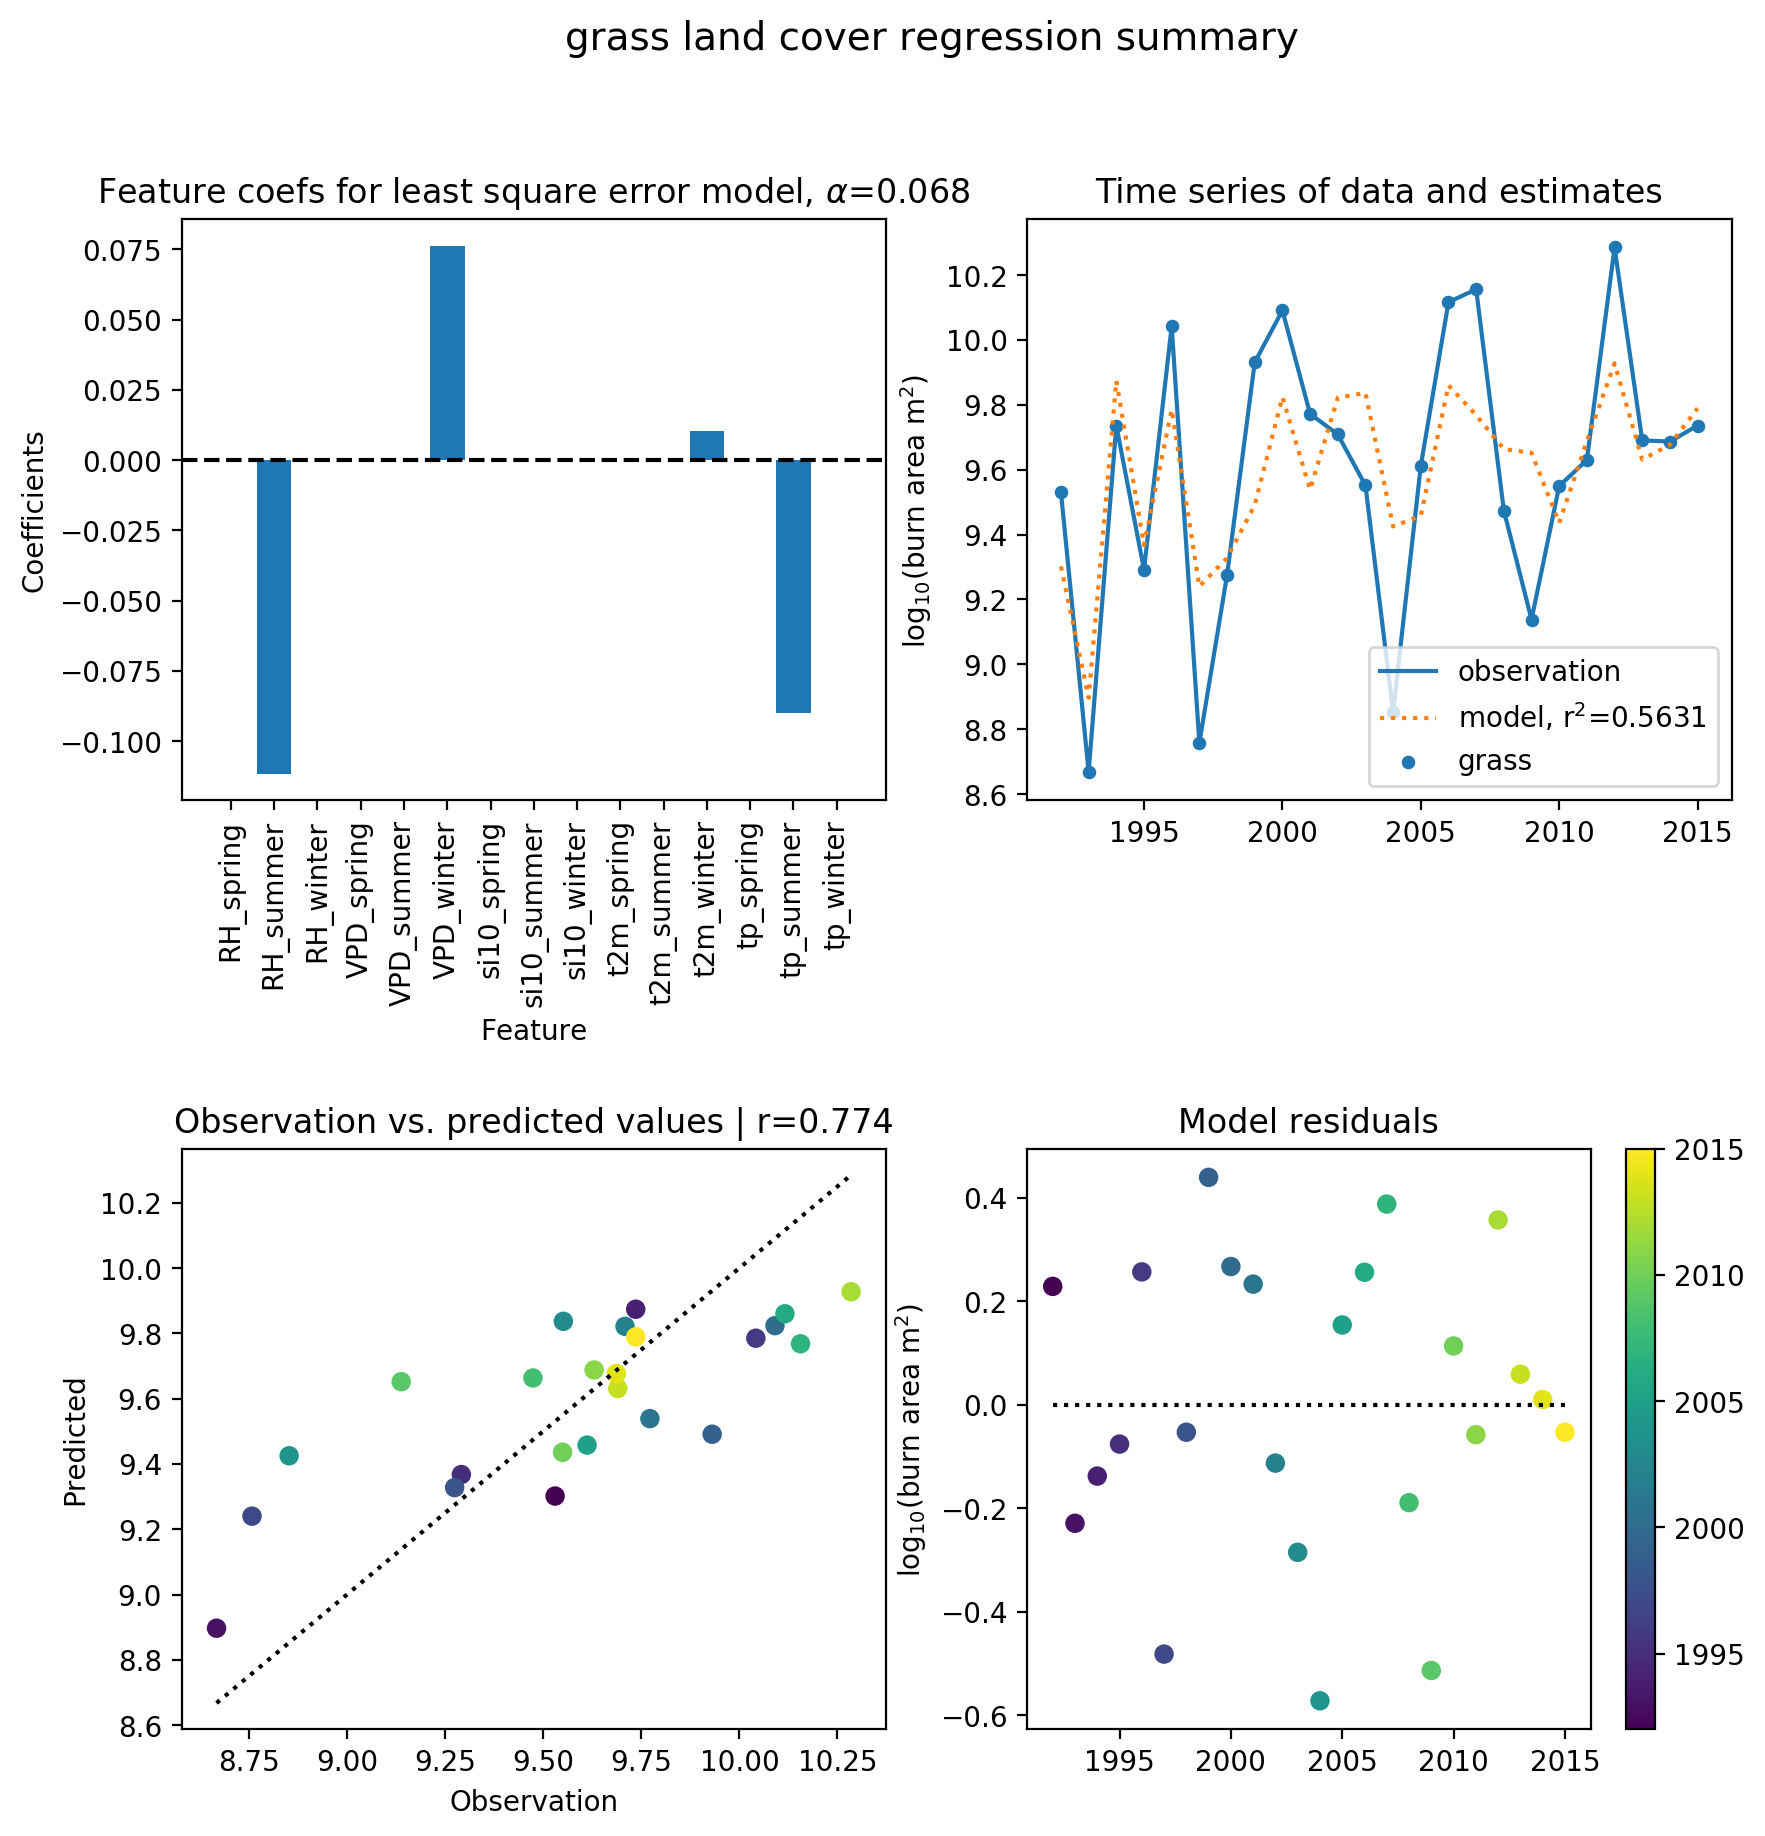

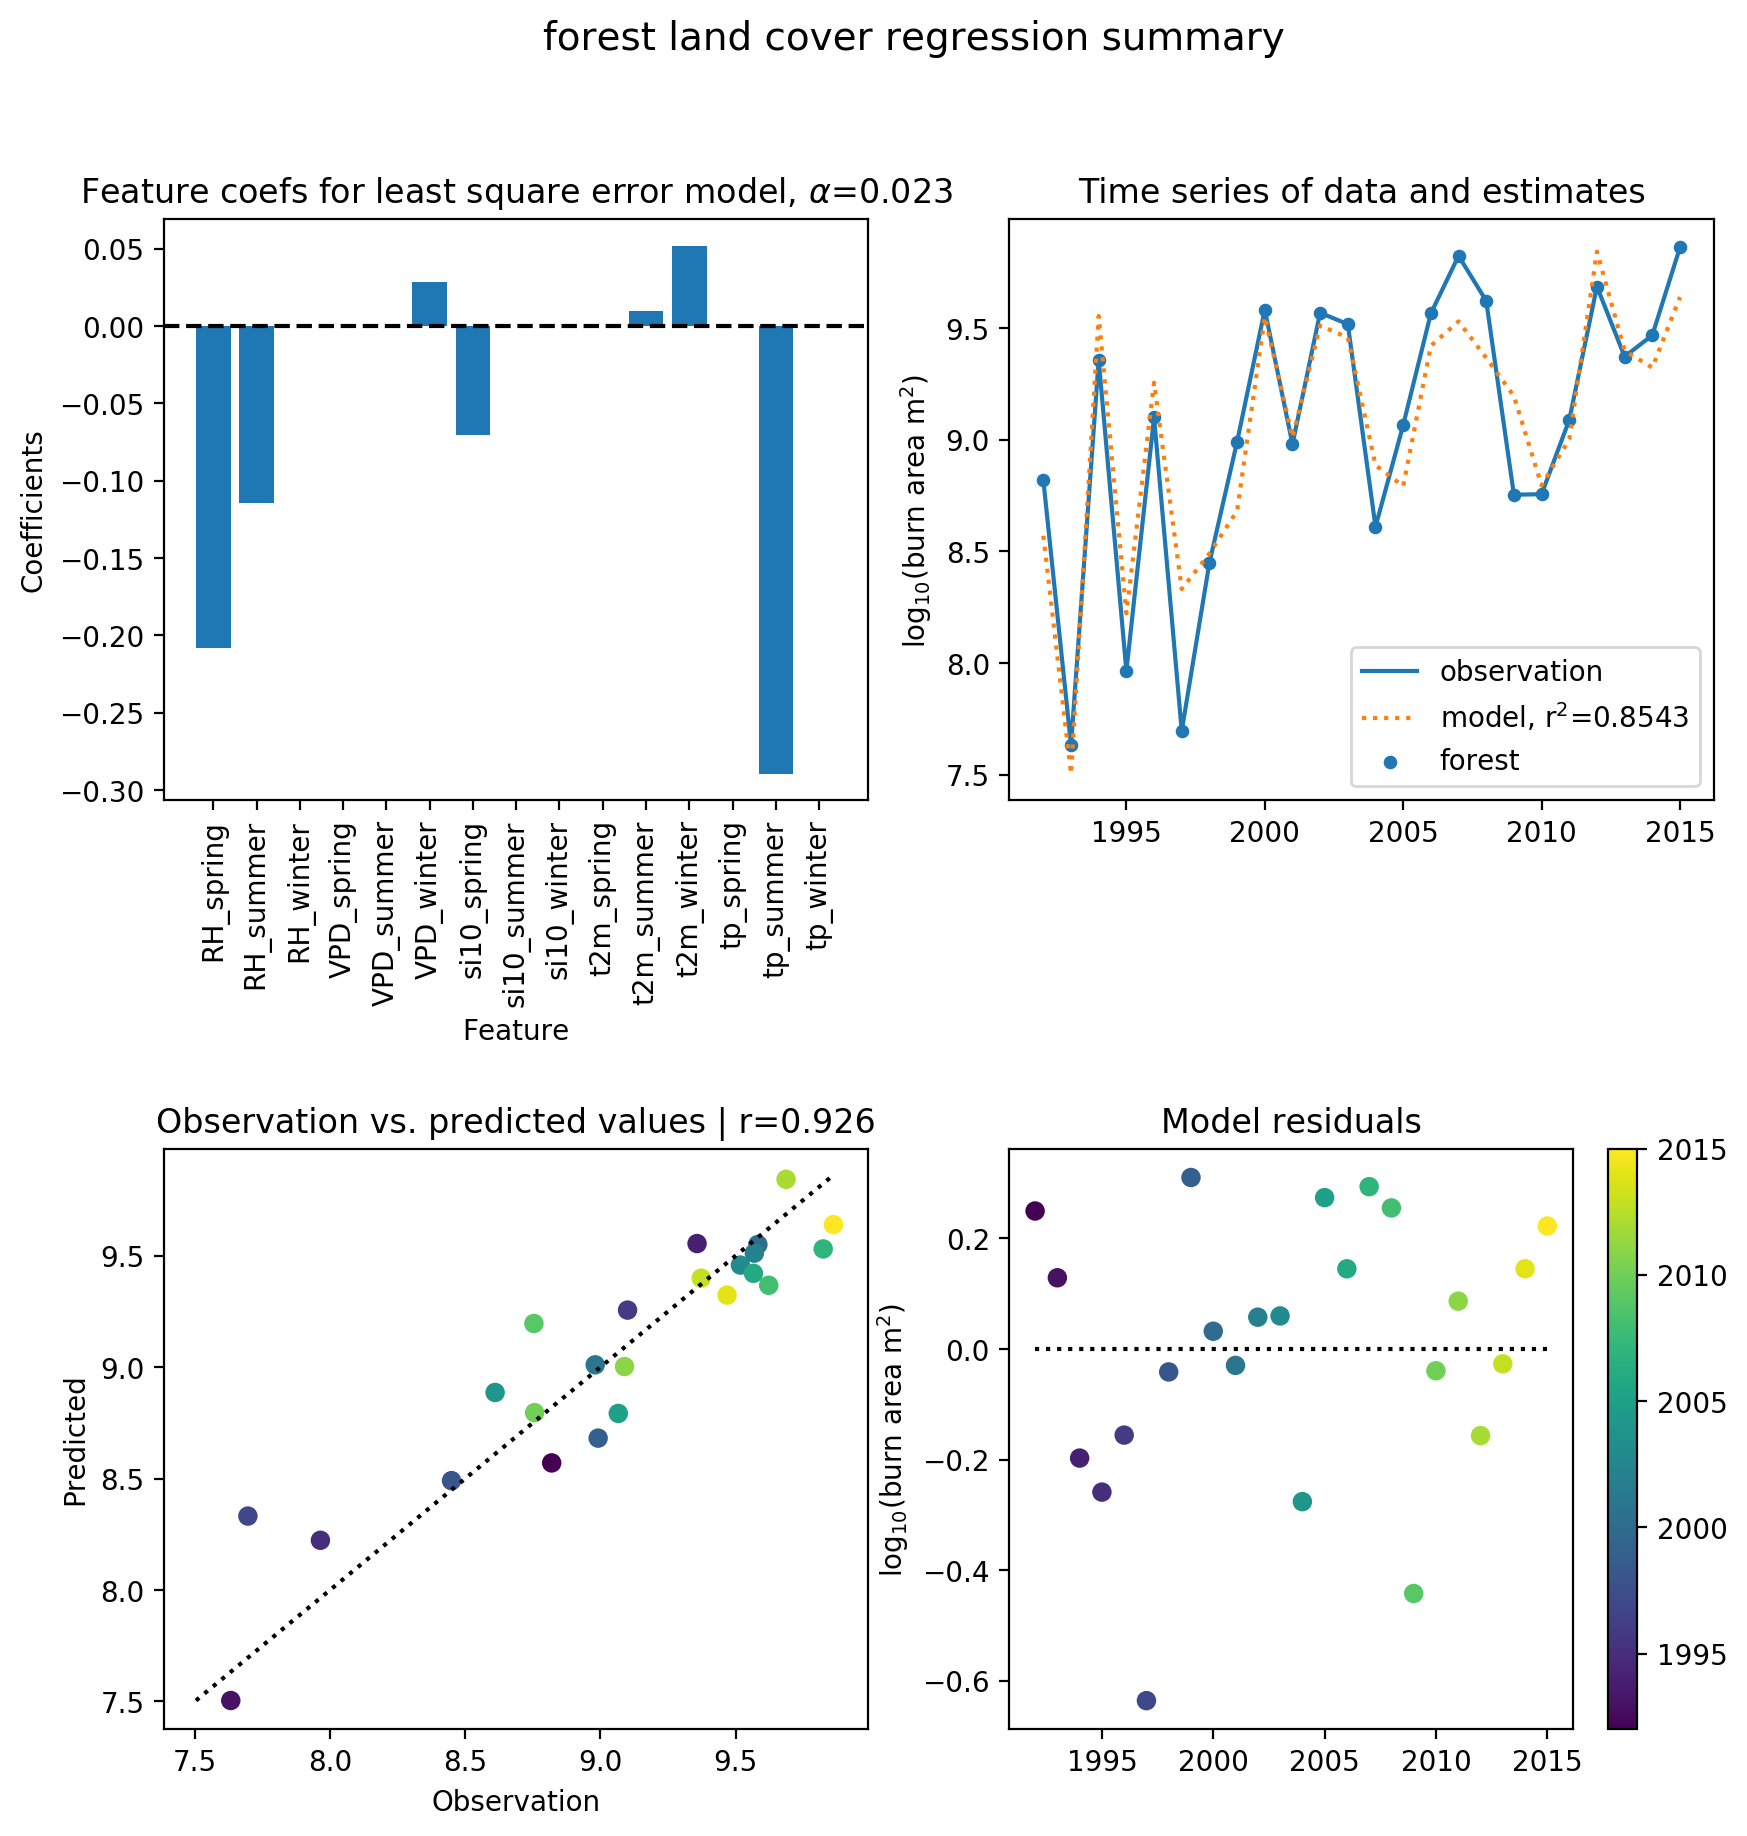

/Users/sbrey/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sbrey/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


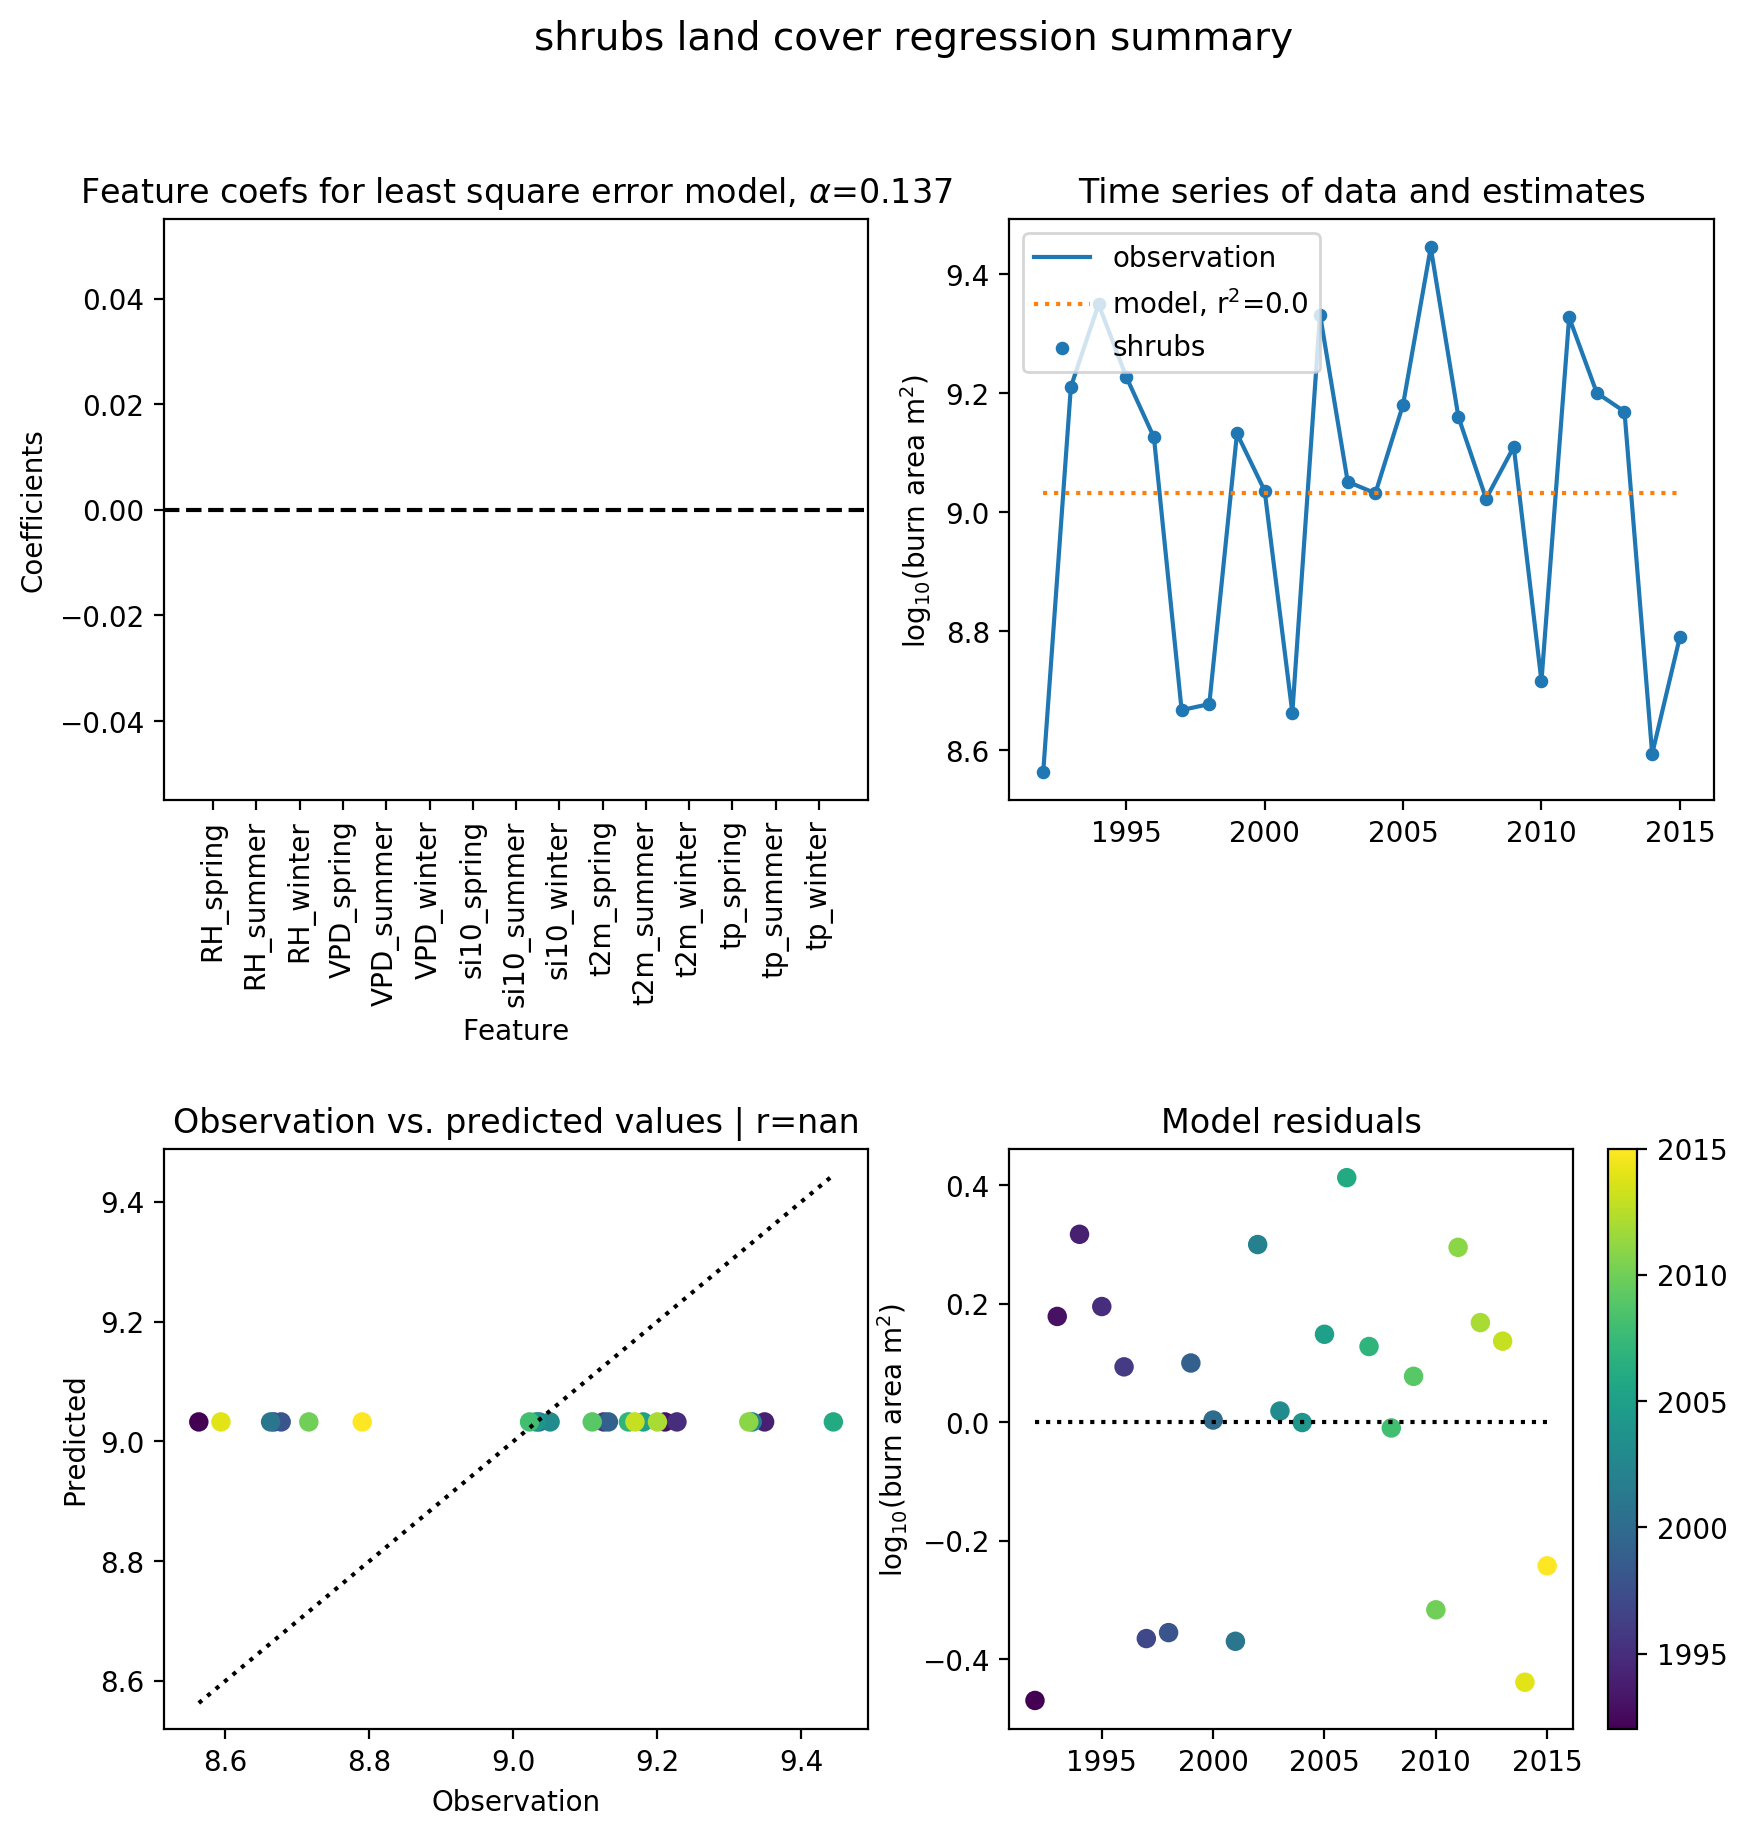

In [28]:
# Create a dictionary that will hold the fitted class instance
# of Lasso() with optimal alpha
model_dict = {}

# Plot the models for the different land covers. 
for target in alpha_CV_dict.keys() :
    
    show_model_skill(target=target, 
                     y=np.log10(df_targets[target]), 
                     Z=Z, 
                     alpha_best=alpha_CV_dict[target], 
                     years=years)
    
    # Store the model. 
    model_dict[target] = Lasso(alpha=alpha_CV_dict[target]).fit(Z, y)

# Predict future burn area using CMIP5 data from RCP45 and RCP85
### As many models as possible. 

In [29]:
def get_cmip5_nc(var="tas", rcp="45", model="ACCESS1-0", minX=0., maxX=360., minY=-90., maxY=90., spatial_mean=True):
    """
    This function will be for loading a particular nc file, which will be spatially subset.
    These CMIP5 model output have been regridded to the "Common grid" using cdo remapbil. 
    
    Parameters
    ----------
    var : str, The CMIP5 variable name to be loaded. File names match variable names. 
    rcp : str, "45" or "85", refers to representative concentration pathway. 
    model : The name of the model that created the var
    minX : float, min longitude (0-360) of the data to return. 
    maxX : float, max longitude (0-360) of the data to return. 
    minY : float, min latitude of the data to return. 
    maxY : float, max latitude of the data to return. 
    spatial_mean : Boolean, if False (default) a spatial mean of the era-interim data
                   is not taken and the data are returned on a t,lon,lat grid. 
                   
    # TODO: Should I only use 2016 onwards? Use the overlapping years to add a bias term? 
    
    """
    
    #print(minX, maxX, minY, maxY)
    
    # Create link to the monthly file
    # TODO: Make dataDir a dynamic global variable
    dataDir = os.path.join(".." ,"Data" ,"CMIP5" ,'r1i1p1_rcp45_rcp85_merged_t_COMMON_GRID')
    f = var + "_" + "Amon_" + model + "_rcp" + rcp + "_r1i1p1_200601-210012.nc"
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! Data logs indicate that not all requests exist
    if(not os.path.isfile(loadFile)):
        raise ValueError(f+ " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 1140):
        # Convert to pandas time array, on the assumption t[0]=2006-01 & t[-1]=2100-12
        t_mon = pd.date_range("2006-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 1140 expected.")
        
        
    # Now subset the data based on the passed max and min values for lon and lat
    lonIndex = np.where( ((lon >= minX) & (lon <= maxX)) )[0]
    latIndex = np.where( ( (lat >= minY) & (lat <= maxY) ) )[0]
    timeIndex = range(len(t)) # because we want all months, for now

    # Subset the 2D field
    lonCut = lon[lonIndex]
    latCut = lat[latIndex]

    # Subset the 3D field
    valsCut = vals[np.ix_(timeIndex, latIndex, lonIndex)]
    
    # Now, take the mean value in this spatial domain. Note, the 
    # same is done to the era-interim data using the method:
    # get_era_nc_vals()
    if spatial_mean :
        spatial_mean = np.mean(valsCut, axis=(1,2))
        valsCut = spatial_mean
    
    return valsCut, t_mon, lonCut, latCut

### TODO: This needs to be a shared function with what was done to make observations seasonal. 

In [30]:
def months_to_seasonal(df, t, variables) :
    """
    Function for taking monthly gridded data and converting to seasonal averages. 
    This has to be handled the exact same way as it is for era-iterim data. 
    
    Parameters
    ----------
    
    df : A pd.Dataframe of monlthy values (rows) for all variables in variables
    t : A pd.date_range that corrospond to the rows of df.
    variables : An array or list of variable names that will be transformed 
                from monthly to seasonal values. 
    
    return
    ------
    
    A pd.DataFame of the monthly data to seasonal predictors for all years
    in the original monthly data (np.unique(t.year)). 
    
    TODO: Combine with functionality used to create the same for era-interim. 
    """
    
    # Get the years
    years  = np.sort(np.unique(t.year))
    nYears = len(years)
    
    # For creating month masks 
    month = pd.Series(t.month)
    seasons = {"winter":[1,2], 
               "spring":[3,4,5], 
               "summer":[6,7,8]}

    # Make a dictionary to store predictors for each variable for each season 
    # of interest. 
    
    predictor_dict = {} # To store predictor information 
    for pre in df.columns:
        for s in seasons.keys():
            predictor_name = pre + "_" + s 
            predictor_dict[predictor_name] = np.zeros(nYears)
            
    #print("Predictor_dict keys")        
    #print(predictor_dict.keys())
            
    # Loop through each year, assigning desired season predictor value 
    # within each year 
    for i in range(nYears):

        # Mask the year of interest, 0 through nYears  
        year_mask = years[i] == t.year

        # Loop through seasons, within a year
        for s in seasons.keys():

            # Mask the months that fall into the current season of interest
            month_mask = month.isin(seasons[s])

            # combine to make a single mask
            tChunk = month_mask & year_mask 

            # For each predictor variable, loop through taking relevant stat
            for pre in df.columns:
                predictor_dict[pre+"_"+s][i] = np.mean(df.loc[tChunk, pre])
    
    # Give the index (rows) years for names. 
    df = pd.DataFrame(predictor_dict)
    df_with_index = df.set_index(years)
    
    return df_with_index

Get CMIP5 model output for predictions 
* Clean up model output that remains flawed on its time axis. 

In [31]:
def make_cmip5_predictors(rcp="85", minX=minX, maxX=maxX, minY=minY, maxY=maxY) :
    """
    This function needs to be double checked.
    Then I need to document its methods, parameters, and returns. 
    """
    
    
    # Converting between cmip5 and era names
    var_dict = {"t2m":'tas', 
                "tp":'pr',
                "si10":'sfcWind',
                "RH":"hurs", 
                "VPD": 'VPD'}

    # Get all models output and store in dictionary
    futures = {}

    # Create a path to the data
    cmip5_dir = os.path.join("..","Data","CMIP5","r1i1p1_rcp45_rcp85_merged_t_COMMON_GRID")

    # Create an array to check if a given cmip5 model has all required output. 
    data_available_mask = []

    for model_name in md.model_name.keys() :

        print("Loading data for model: " + model_name)

        # Check to see if all needed variables exist before 
        file_exists = []
        for var in var_dict.values() :
            f = os.path.join(cmip5_dir, var+"_Amon_"+model_name+"_"+"rcp85"+"_r1i1p1_200601-210012.nc")
            exists = os.path.exists(f)
            file_exists.append(exists)

        # If all in file_exists are true, get the data. 
        if np.sum(file_exists) == len(file_exists) :

            # Temp storage for model output
            model_dict = {} 
            for var in var_dict.keys() :

                # Until I re-clean the data, check to make sure it loads 
                try :
                    # Get the values for this model, scenario, and variable
                    var_vals, cmip_t, cmip_lon, cmip_lat = get_cmip5_nc(var=var_dict[var], 
                                                                        rcp=rcp, 
                                                                        model=model_name, 
                                                                        minX=minX, maxX=maxX, minY=minY, maxY=maxY, 
                                                                        spatial_mean=True)

                except ValueError:
                    print("unable to load " + var)

                # Store the values
                model_dict[var] = var_vals

            # Convert to a df for easier handling
            model_monthly = pd.DataFrame(model_dict)

            # Convert to seasonal predictors. 
            model_seasonal = months_to_seasonal(df=model_monthly, t=cmip_t, variables=var_dict.values())
            futures[model_name] = model_seasonal

        else :
            print("Skipped " + model_name + " not all variables available.")

    # Columns are no longer months, they are years. 
    cmip_years = np.sort(np.unique(cmip_t.year))
            
    return futures, cmip_years

In [32]:
print("Getting RCP 8.5")
futures85, cmip_years = make_cmip5_predictors(rcp="85", minX=minX, maxX=maxX, minY=minY, maxY=maxY)
print("Getting RCP 4.5")
futures45, cmip_years = make_cmip5_predictors(rcp="45", minX=minX, maxX=maxX, minY=minY, maxY=maxY)

Getting RCP 8.5
Loading data for model: ACCESS1-0
Loading data for model: ACCESS1-3
Loading data for model: IPSL-CM5B-LR
Loading data for model: CMCC-CMS
Skipped CMCC-CMS not all variables available.
Loading data for model: MIROC-ESM
Loading data for model: MIROC5
Loading data for model: CanESM2
Loading data for model: MPI-ESM-MR
Skipped MPI-ESM-MR not all variables available.
Loading data for model: CSIRO-Mk3-6-0
Loading data for model: inmcm4
Loading data for model: GISS-E2-R-CC
Loading data for model: CCSM4
Skipped CCSM4 not all variables available.
Loading data for model: GFDL-ESM2G
Loading data for model: CMCC-CM
Skipped CMCC-CM not all variables available.
Loading data for model: GFDL-ESM2M
Loading data for model: NorESM1-M
Skipped NorESM1-M not all variables available.
Loading data for model: IPSL-CM5A-MR
Loading data for model: IPSL-CM5A-LR
Loading data for model: GFDL-CM3
Loading data for model: CNRM-CM5
Loading data for model: GISS-E2-H
Loading data for model: MIROC-ESM-CHEM


### Precipitation distributions before standardization

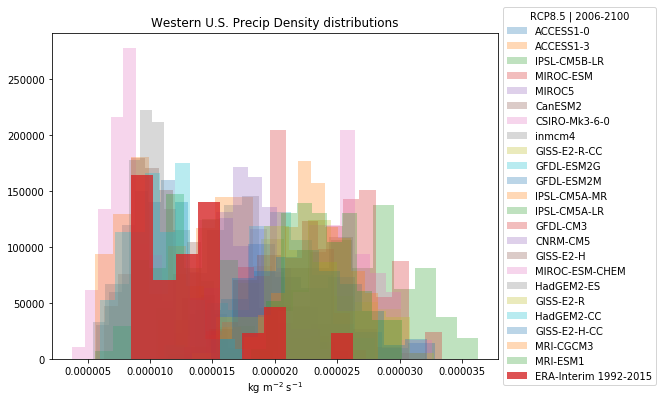

In [33]:
plt.figure(figsize=(10,6))
ax=plt.subplot(111)

for model in futures85.keys() :
    plt.hist(futures85[model].loc[:,"tp_summer"].values, density=True, label=model, alpha=0.3)

plt.hist(era_df_features['tp_summer'].values, density=True, label="ERA-Interim 1992-2015", alpha=0.8)

plt.xlabel("kg m$^{-2}$ s$^{-1}$")
plt.title("Western U.S. Precip Density distributions")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 2006-2100")

plt.show()

### Make predictions using CMIP5 model output. One prediction per model per scenario. 
#### Here is what has to happen to predict future burn area using CMIP output

- The bias of each CMIP5 model needs to be addressed. This will be done via the following equation

$$x_{bias-corrected_{CMIP5}}=(x_{CMIP5_{2006-2100}}-\overline{x_{CMIP5_{2006-2100}}})+\overline{x_{historical_{2006-2015}}}$$

This replaces the CMIP5 bias with the historical bias. This should make it so that a time series of the historical value and the projected value are roughly aligned in the first decade of the 21st century. 

- CMIP5 model variables  need to be standardized using the following equation (where x is some variable). 

$$x\prime=\frac{x_{bias-corrected_{CMIP5}}-\overline{x_{historical}}}{\sigma_{historical}}$$

- $x\prime$ is the matrix that will be fed into the trained linear model's $predict()$ methed to estimate future wildfire burn area. 

- This about what version of the historical data needs to be plotted along side the projected values using the trained regressions. 

### Standardize CMIP5 output using historical variance and mean

In [34]:
def cmip_bias_correction(cmip5_df_features, era_df_features, feature) :
    """
    This function corrects the bias in CMIP5 seasonal output by using the 
    overallping years between CMIP5 output and era-reanalysis data. This is
    done by removing the 2006-2015 mean value of the cmip5 feature of interest
    and replacing it with the same years mean value from the reanlaysis data. 
    
    Parameters
    ----------
        cmip5_df_features : A pd.DataFrame of cmip5 features. [year x feature]
        era_df_features : A pd.DataFrame of era-interim features. [year x feature]. 
                          Must have the exact same names as cmip5_df_features. 
                          
    Return
    ------
        A np.array(dtype=float) of the cmip5 feature data array where the bias
        has been corrected. 
    """

    # Take the overlapping time period mean values for era and cmip
    era_overlap_mean = np.array(era_df_features.loc[2006:2015, feature]).mean()
    cmip5_overlap_mean = np.array(cmip5_df_features.loc[2006:2015, feature]).mean()
    # Remove the CMIP5 mean value
    cmip_feature_no_bias = np.array(cmip5_df_features[feature]) - cmip5_overlap_mean
    # Replace the CMIP5 mean value with the reanalysis mean value 
    cmip_feature_with_era_bias = cmip_feature_no_bias + era_overlap_mean
    
    return cmip_feature_with_era_bias

### Demonstration of bias correction method

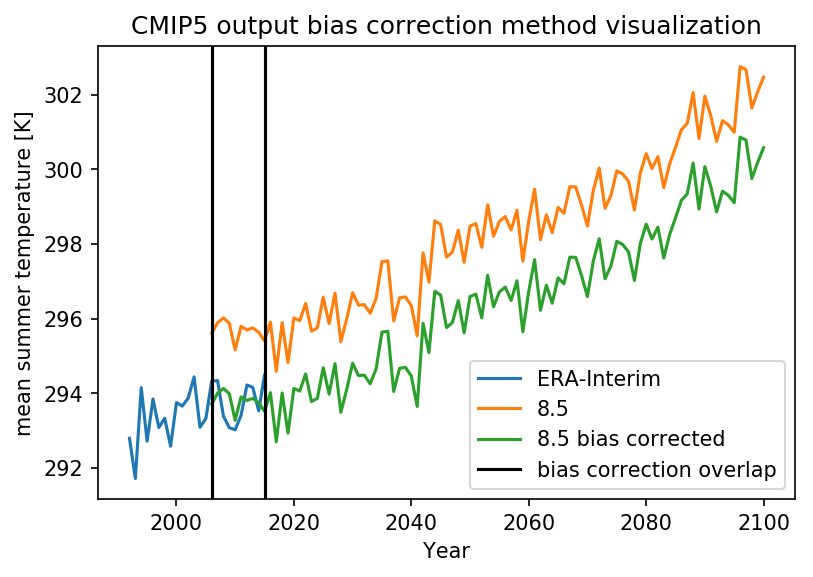

In [35]:
cmip_feature_with_era_bias = cmip_bias_correction(futures85['ACCESS1-0'], era_df_features, "t2m_summer")

plt.figure(dpi=150)
plt.plot(era_years, era_df_features["t2m_summer"], label="ERA-Interim")
plt.plot(cmip_years, futures85['ACCESS1-0']["t2m_summer"].values, label="8.5")
plt.plot(cmip_years, cmip_feature_with_era_bias, label="8.5 bias corrected")
plt.ylabel("mean summer temperature [K]")
plt.xlabel("Year")
plt.title("CMIP5 output bias correction method visualization")
plt.axvline(2006, c='k', label="bias correction overlap")
plt.axvline(2015, c='k')
plt.legend()
plt.show()

### Standardize the CMIP5 output and handle bias. 

In [36]:
def standardize_cmip(cmip_dict, era_df_features) : 
    """
    Standardizes historical output using era reanlysis data fields. The 
    cmip5 model output bias is first corrected using cmip_bias_correction()
    then then standardized using historical (1992-2015) variance and width. 
    
    Parameters
    ----------
        cmip5_dict : A dictionary of CMIP5 output in pd.DataFrames. This 
                     function will loop over these models creating Z. 
        era_df_features : a pd.Dataframe of era features. Must exactly match
                          the features (columnames) in cmip5_dict dataframes. 
                          ERA feature means and standard deviations are 
                          calculated using this dataframe. 
                          
        Return
        ------
            A dictionary of pd.Dataframe where the keys are cmip5 model names
            and the values are the features standarized using historical (era)
            mean and variance. 
    """
    #print("--------------------")
    #print("Standardizing output")
    #print("--------------------")
    
    era_df_features = era_df_features.copy()
    
    # Get the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    era_ref_mean = era_df_features.mean().copy()
    era_ref_std  = era_df_features.std().copy()
    
    # A dictionary to store the standardized output 
    Z_futures_dict = {}
    
    # Get model names to loop over 
    model_names = cmip_dict.keys()
    n_models = len(model_names) 

    for model_name in model_names : 

        #print("Standardizing %s model output" % model_name)

        # Get the Cmip5 features dataframe fromt the futures dict.
        cmip5_df_features = cmip_dict[model_name].copy()
        cmip_years = np.array(cmip5_df_features.index)
        n_features = cmip5_df_features.shape[1]

        cmip5_col_names = np.array(cmip5_df_features.columns.values)
        # np.array to store standardized values 
        Z_future = np.zeros(shape=cmip5_df_features.shape)

        # Standardize (using historical mean and variance) 
        # the columns of these CMIP5 output 
        for i in range(n_features) : 

            feature = cmip5_col_names[i]
            #print("feature being standardized: %s" % feature)

            # Handle bias
            feature_bias_corrected = cmip_bias_correction(cmip5_df_features, era_df_features, feature)

            # Standardize with historical values
            Z_future[:, i] = (feature_bias_corrected - era_ref_mean[i]) / era_ref_std[i]

        # Convert the np.array to a pd.DataFrame for nice storage. 
        Z_future_df = pd.DataFrame(Z_future, columns=cmip5_col_names, index=cmip_years)
        # Store in the dictionary
        Z_futures_dict[model_name] = Z_future_df
        
    #print("--------------------")
    #print("Output standardized")
    #print("--------------------")        
    
    return Z_futures_dict

In [37]:
Z_futures85_dict = standardize_cmip(futures85, era_df_features)
Z_futures45_dict = standardize_cmip(futures45, era_df_features)

del Z_futures85_dict["MRI-ESM1"]
del Z_futures45_dict["MRI-ESM1"]

### Plot Z time series to make sure standardization and bias correction worked as estimated 

In [51]:
def plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, feature) : 
    
    fig = plt.figure(dpi=200)

    for i in Z_futures85_dict.keys() : 
        plt.plot(cmip_years, Z_futures85_dict[i][feature].values, c="r")
        if np.max(Z_futures85_dict[i][feature].values) > 1000 : 
            print("model with wack values is: " + i)
        
    for j in Z_futures45_dict.keys() : 
        plt.plot(cmip_years, Z_futures45_dict[j][feature].values, c="blue")
        if np.max(Z_futures45_dict[j][feature].values) > 1000 : 
            print("model with wack values is: " + j)
        
    # Place the historical record on at the end. 
    y = Z[feature].copy()
    plt.plot(np.array(Z.index.values), y, c="green")
    #ymin = np.min(y) - 5. * np.std(y)
    #ymax = np.max(y) + 10. * np.std(y)
    #plt.ylim([ymin, ymax])
    plt.xlabel("Year")
    plt.ylabel(feature + " [$\sigma$]")
    plt.title(feature)
    plt.show()

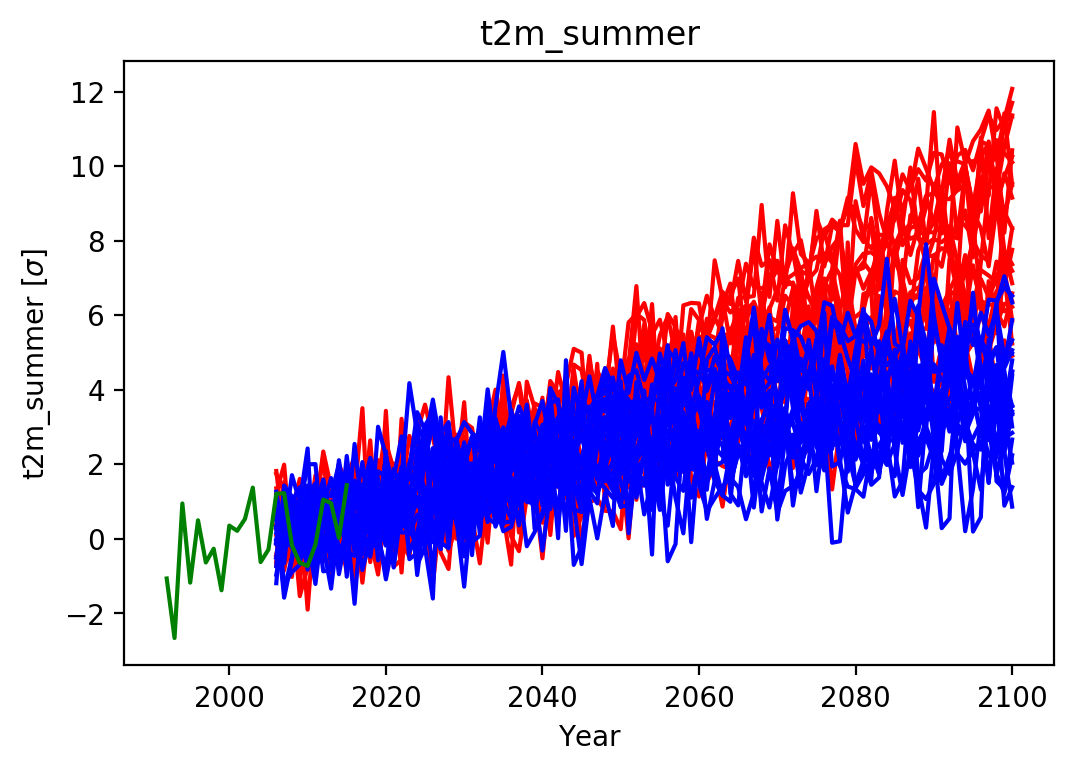

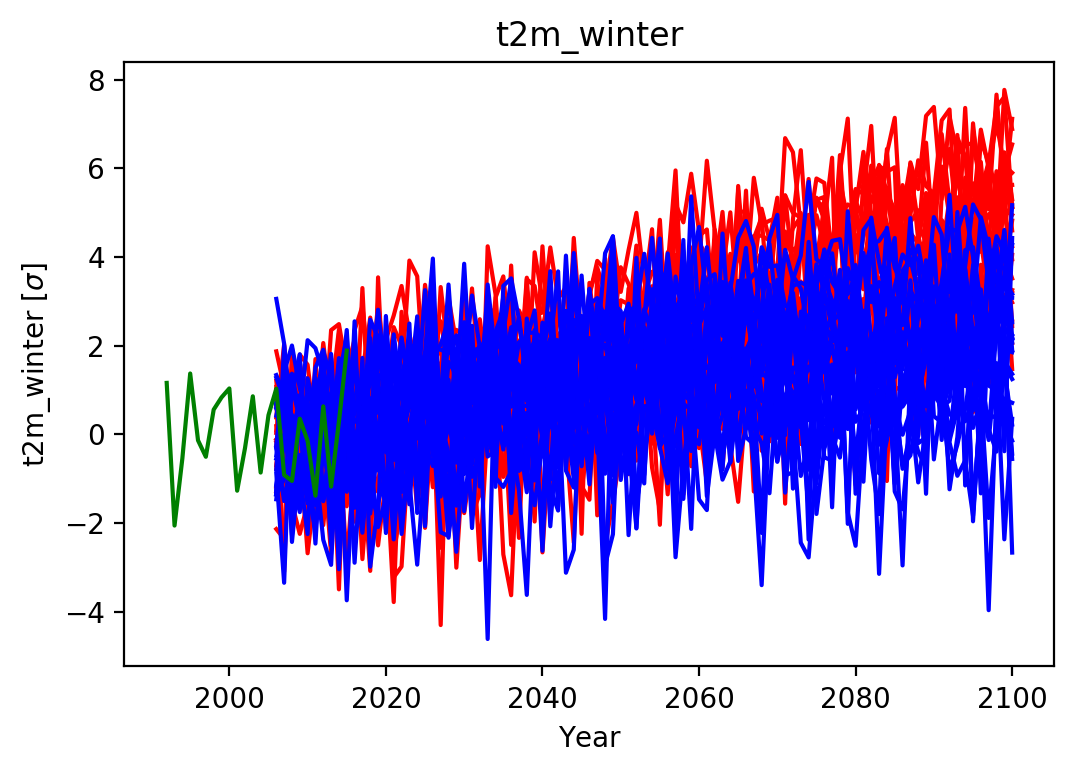

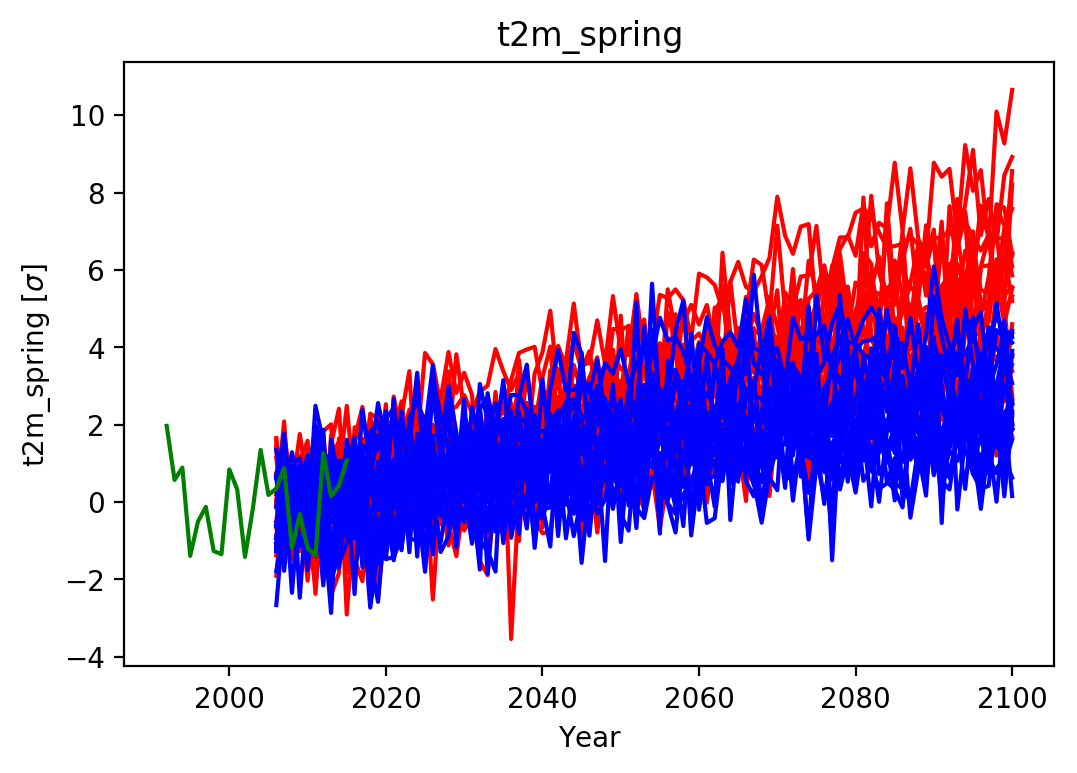

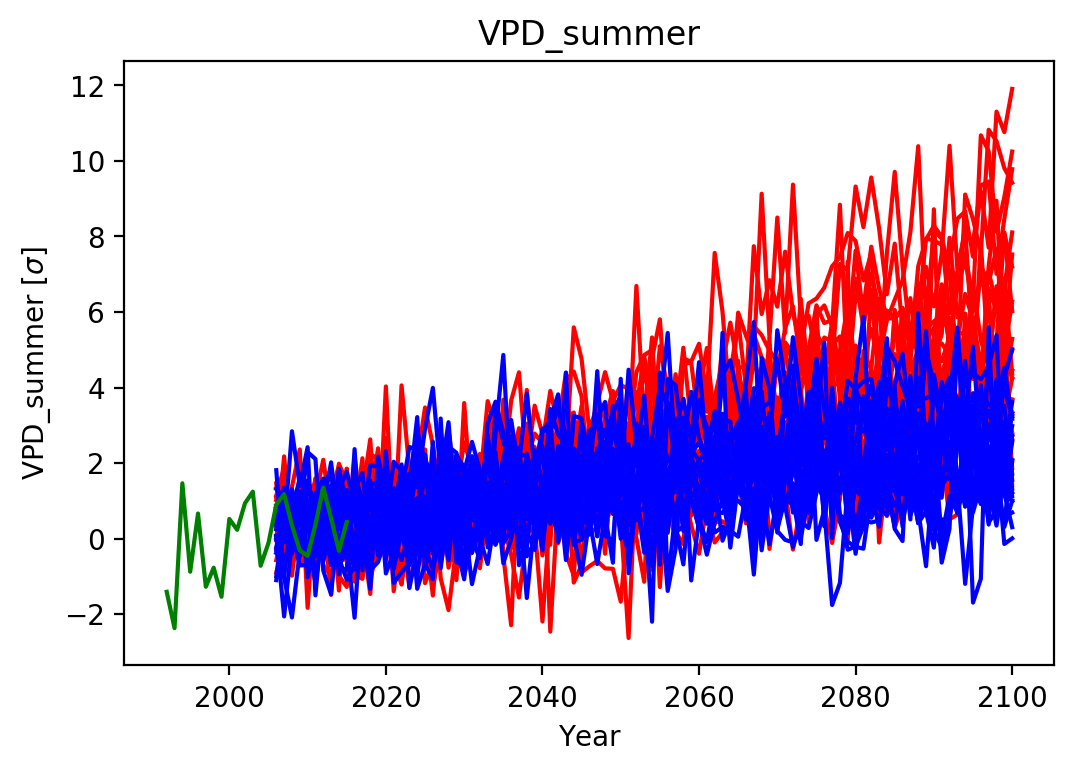

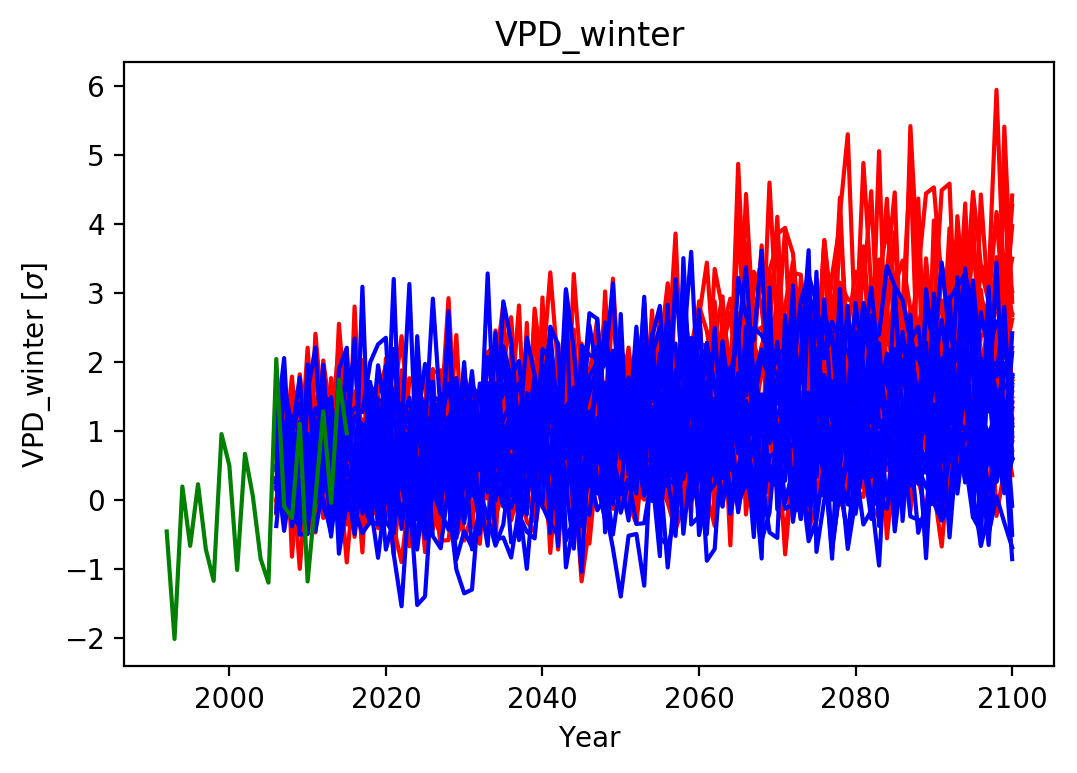

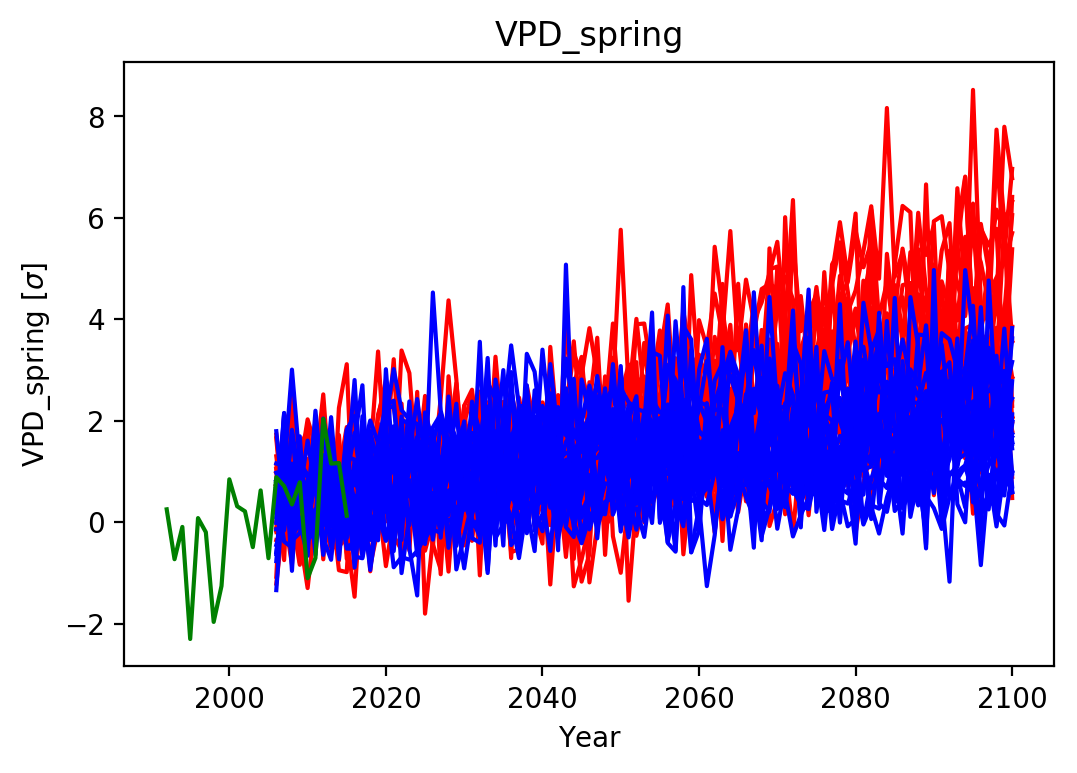

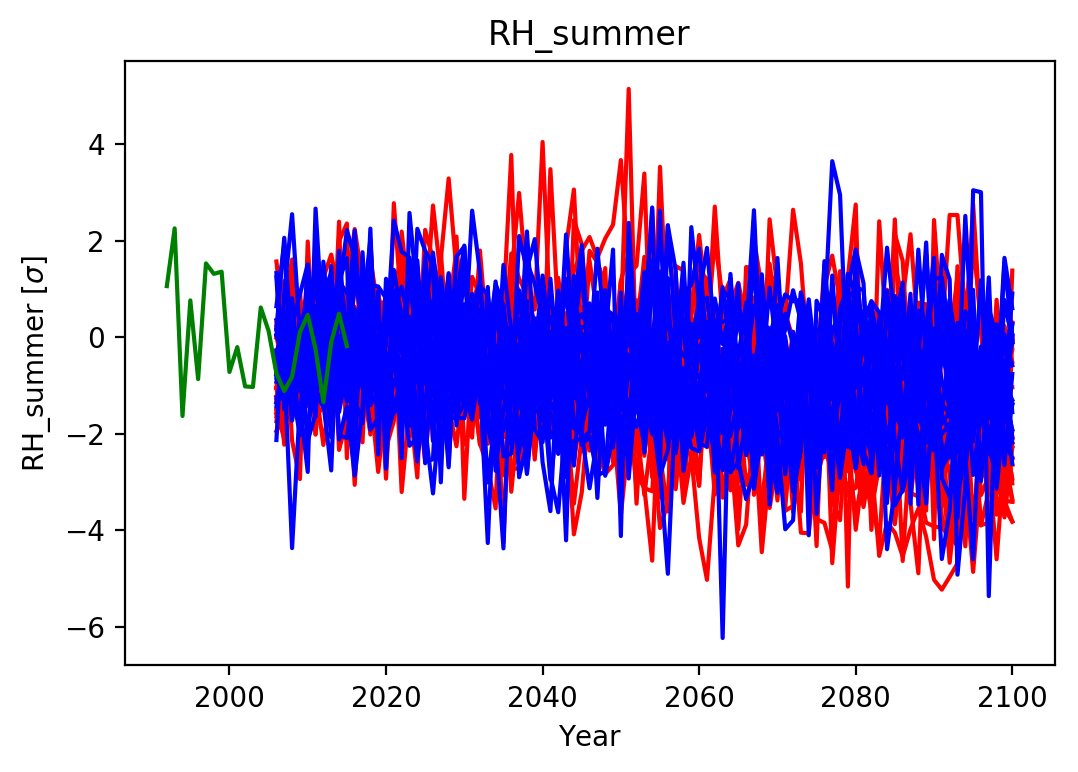

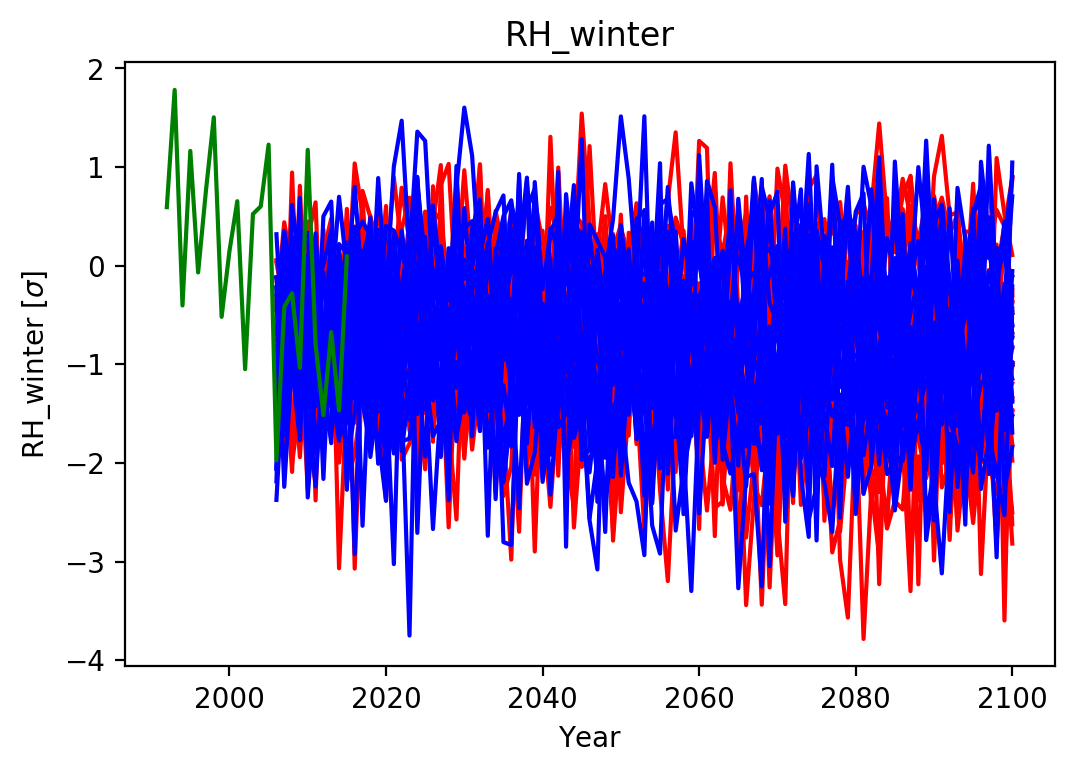

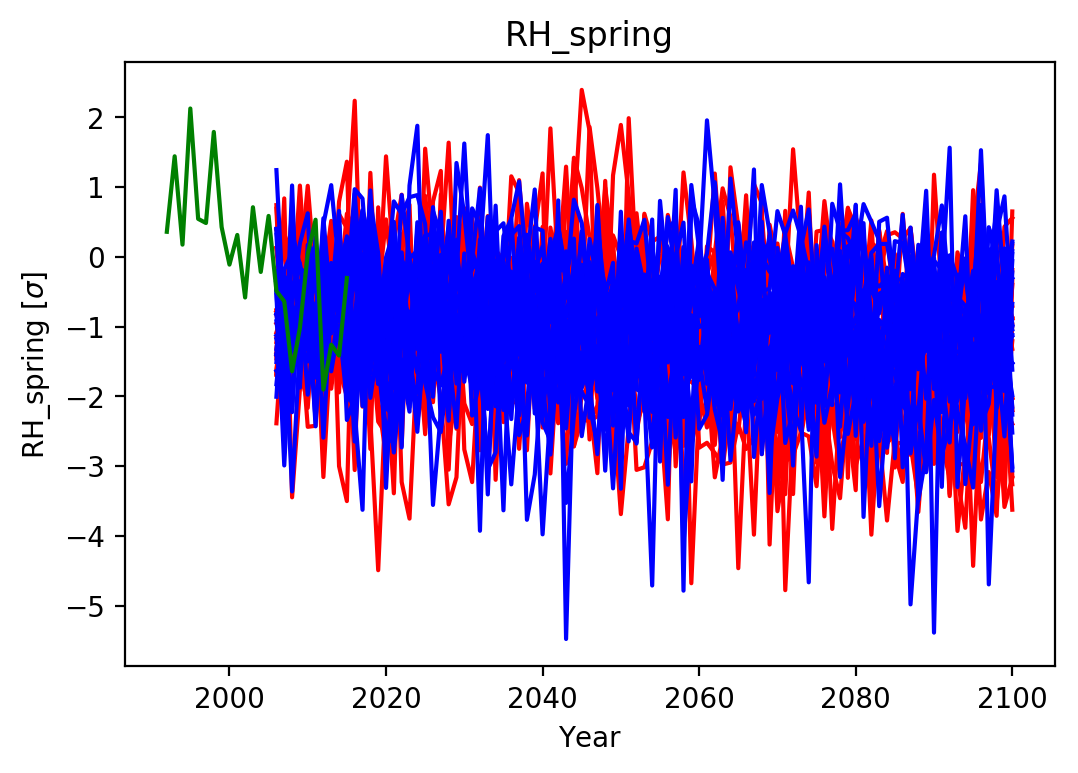

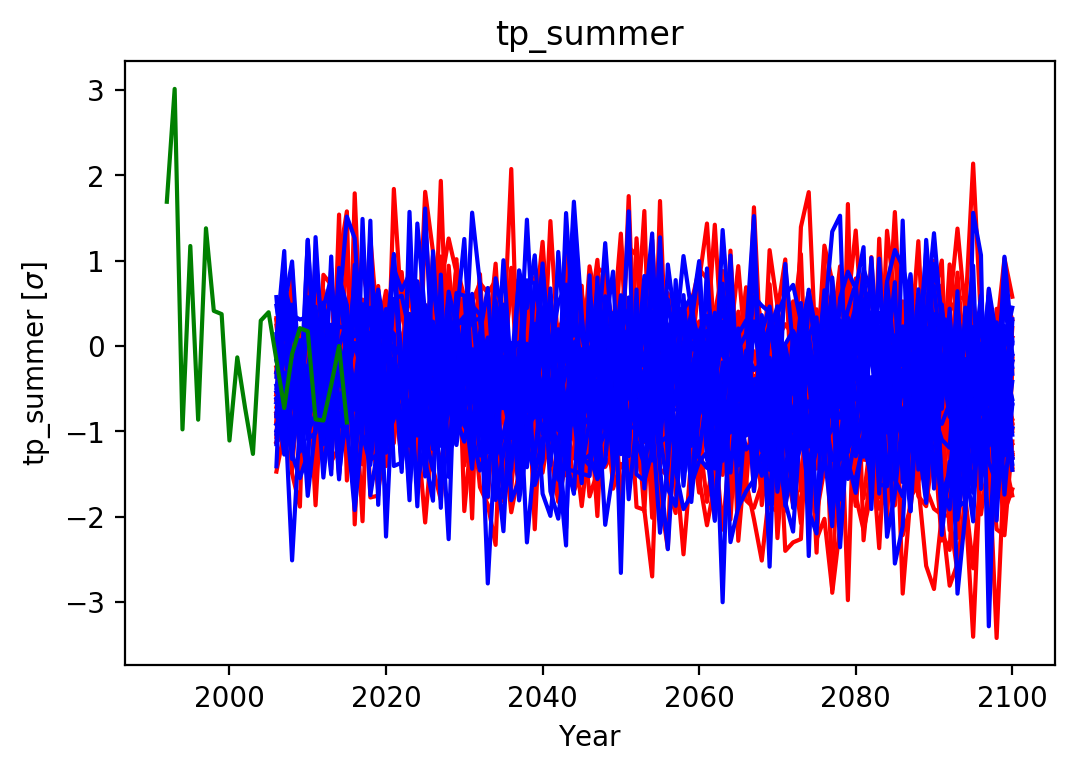

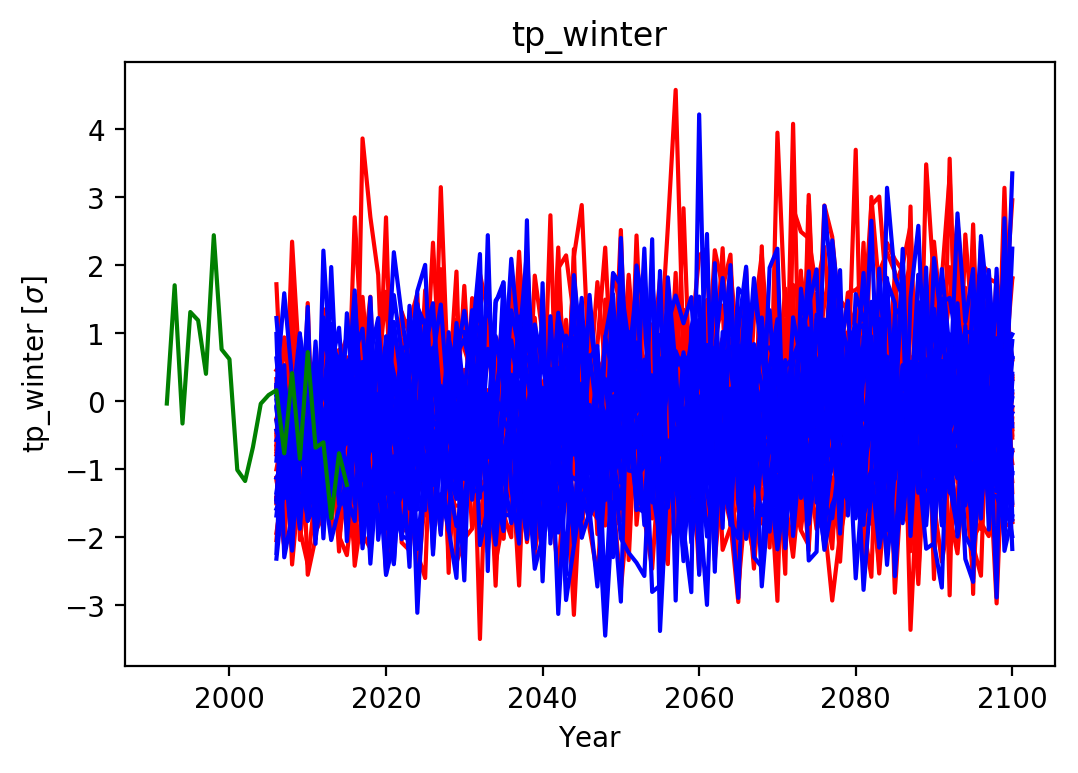

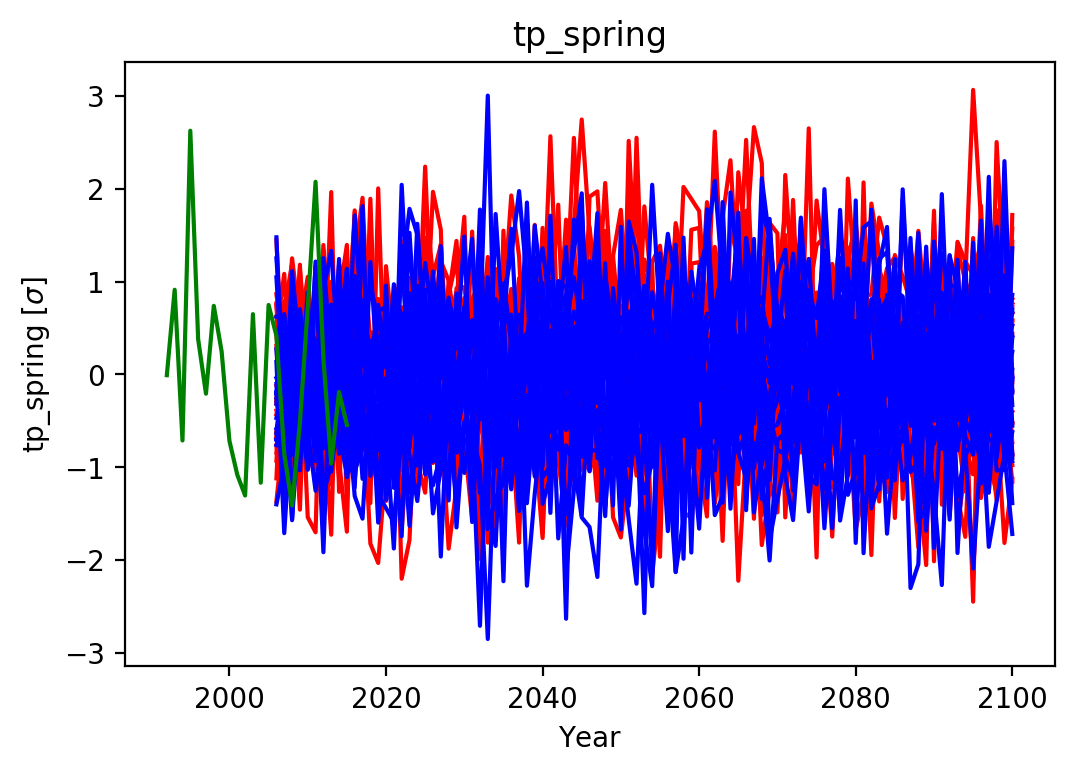

In [52]:
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "t2m_summer")
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "t2m_winter")
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "t2m_spring")

plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "VPD_summer")
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "VPD_winter")
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "VPD_spring")

plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "RH_summer")
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "RH_winter")
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "RH_spring")

plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "tp_summer")
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "tp_winter")
plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, "tp_spring")

(array([ 3.,  6., 12., 15., 14., 16., 14.,  4.,  7.,  4.]),
 array([-1.87377967, -1.62607548, -1.37837129, -1.1306671 , -0.88296292,
        -0.63525873, -0.38755454, -0.13985035,  0.10785384,  0.35555803,
         0.60326222]),
 <a list of 10 Patch objects>)

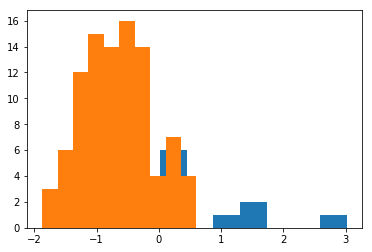

In [40]:
plt.hist(Z.loc[:,"tp_summer"])
plt.hist(Z_futures85_dict["ACCESS1-0"].loc[:,"tp_summer"])

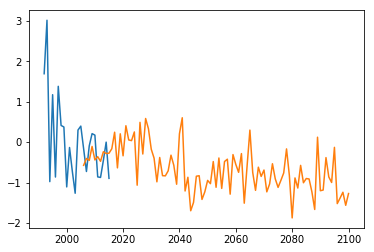

In [41]:
plt.plot(era_years, Z.loc[:,"tp_summer"])
plt.plot(cmip_years, Z_futures85_dict["ACCESS1-0"].loc[:,"tp_summer"])

In [42]:
futures85.keys()

['ACCESS1-0',
 'ACCESS1-3',
 'IPSL-CM5B-LR',
 'MIROC-ESM',
 'MIROC5',
 'CanESM2',
 'CSIRO-Mk3-6-0',
 'inmcm4',
 'GISS-E2-R-CC',
 'GFDL-ESM2G',
 'GFDL-ESM2M',
 'IPSL-CM5A-MR',
 'IPSL-CM5A-LR',
 'GFDL-CM3',
 'CNRM-CM5',
 'GISS-E2-H',
 'MIROC-ESM-CHEM',
 'HadGEM2-ES',
 'GISS-E2-R',
 'HadGEM2-CC',
 'GISS-E2-H-CC',
 'MRI-CGCM3',
 'MRI-ESM1']

### Use the standardized CMIP output to make predictions using the trained linear classifier

In [43]:
def calculate_future_BA(model_dict, Z_futures_dict) :
    """
    TODO: Document me! 
    """
    # Dictionary to store the df of predictions
    BA_future_dict = {}

    for LC in model_dict.keys() : 
        
        # To store individual model predictions for this land cover
        temp_dict = {}
        
        # Get the trained linear classifier for this land cover
        m = model_dict[LC]
        #print("Model parameters for LC=  " + LC)
        #print(m.coef_)
        #print(m.alpha)
        
        for cmip_model in Z_futures_dict.keys() : 

            # Use the trained classifier to make a prediction
            Z_pred_features = Z_futures_dict[cmip_model].copy()
            BA_future_pred = m.predict(Z_pred_features)
            temp_dict[cmip_model] = BA_future_pred
        
        # Make into a DataFrame. 
        burn_area = pd.DataFrame(temp_dict, index=Z_pred_features.index.values)
        
        BA_future_dict[LC] = burn_area.copy()
        del burn_area
    
    return BA_future_dict

In [44]:
RCP_85_burn_areas = calculate_future_BA(model_dict, Z_futures85_dict)
RCP_45_burn_areas = calculate_future_BA(model_dict, Z_futures45_dict)

In [54]:
RCP_85_burn_areas["forest"]

ACCESS1-0  ACCESS1-3  CNRM-CM5  CSIRO-Mk3-6-0   CanESM2  GFDL-CM3  \
2006   9.198207   9.030119  9.284329       9.178019  8.999148  8.806368   
2007   9.025093   9.055922  9.084554       9.162803  9.281637  9.020906   
2008   8.990636   8.936908  9.087901       8.991456  9.125012  8.913317   
2009   9.058508   9.345643  9.046031       9.199453  9.049811  9.039829   
2010   9.030113   8.984035  8.977649       9.016510  8.790160  9.187878   
2011   9.179218   9.179179  9.184882       9.141781  8.871149  9.226020   
2012   8.996972   9.046194  8.825744       8.982035  9.121136  9.073288   
2013   9.110267   9.104683  9.089035       9.083433  9.126132  8.849977   
2014   9.079555   9.091305  9.099488       8.993515  9.213127  9.452686   
2015   9.052078   8.946659  9.041035       8.971642  9.143336  9.150379   
2016   9.016396   9.081656  8.912566       9.301881  8.947016  8.974554   
2017   8.943564   8.987975  8.997406       9.243336  9.201534  8.972565   
2018   9.127808   8.857314  9.029406       9.086445  9.123259  9.015904   
2019   9.134441   9.216476  9.094221       9.077918  9.254056  8.937731   
2020   9.239651   8.945847  9.299097       9.228103  9.111734  9.107404   
2021   9.127565   9.226548  9.135715       9.053579  9.102910  9.191992   
2022   8.988187   9.021651  8.941338       9.282657  9.161881  8.852610   
2023   9.143905   8.811294  8.928855       9.189362  9.061988  8.757768   
2024   8.978090   8.984220  9.242697       9.095232  9.227226  8.815560   
2025   9.319934   8.977871  9.167127       9.087338  9.212924  8.956063   
2026   8.875968   8.897113  8.854046       8.931943  9.015304  8.647001   
2027   9.034701   8.795249  9.027751       9.094491  8.938710  8.824533   
2028   8.943291   9.196253  9.050570       9.229792  9.174176  9.152758   
2029   8.946244   8.915414  9.205334       9.149628  9.015605  8.946670   
2030   9.094344   8.863496  9.290277       9.163001  8.847560  8.712590   
2031   9.115254   8.818127  9.038735       9.042372  9.054489  8.981117   
2032   9.382714   8.948427  8.867989       9.040634  8.619846  8.926514   
2033   9.140037   9.234649  9.025288       8.934165  9.052430  8.901227   
2034   9.224524   8.998433  9.151845       9.140979  9.025856  9.306949   
2035   9.176016   9.134826  9.142259       9.070751  8.847834  8.970055   
...         ...        ...       ...            ...       ...       ...   
2071   9.343565   9.032264  9.173559       9.113733  8.729387  8.878576   
2072   9.356727   9.079285  9.109737       9.152775  8.760477  9.046633   
2073   9.376198   9.105940  9.121888       9.200158  9.095922  8.879897   
2074   9.361679   8.882638  9.228250       9.179658  9.008684  8.901640   
2075   9.351838   9.106901  9.071410       9.245226  8.919672  9.266253   
2076   9.279696   8.888269  9.130244       9.150951  8.962281  8.680787   
2077   9.433060   8.883887  9.140392       9.122347  8.814592  8.984558   
2078   9.184007   8.855523  9.033433       9.178891  8.569133  9.081876   
2079   9.260081   9.088152  9.205714       8.977756  8.745533  8.803842   
2080   9.592708   8.901342  9.071435       9.296642  8.547775  8.952809   
2081   9.300219   8.970694  9.036102       9.155456  8.920312  9.070200   
2082   9.250585   9.005158  9.013411       9.147495  8.796720  8.829960   
2083   9.112317   8.981776  9.158855       9.236836  8.692183  8.830231   
2084   9.240078   9.025419  9.047580       9.036837  8.785395  9.064977   
2085   9.290940   8.676073  9.327426       9.092253  9.076702  8.849680   
2086   9.215085   9.082144  9.210575       9.184258  8.612647  8.819056   
2087   9.396312   8.786882  9.183222       9.046351  8.847528  8.875239   
2088   9.522742   8.900450  9.219702       9.303496  8.828538  8.706459   
2089   9.018481   9.178247  9.007851       9.216592  8.733315  8.710546   
2090   9.220792   8.839039  8.923294       9.343473  8.757348  9.279619   
2091   9.425137   8.954774  8.911375       9.238260  8.966427  8.641024   
2092   9.187537   8.987649  9.1

#### Does all this messing with different land cover give us a different total burn area? 

historical breakdown of burn area

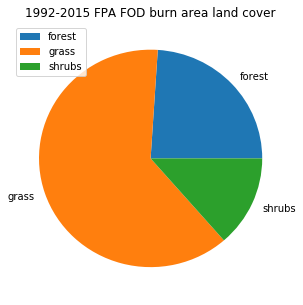

In [45]:
df_targets_subset = df_targets.iloc[:,1:]
LC_frac = df_targets_subset.sum() / df_targets_subset.sum().sum()

plt.figure(figsize=(5,5))
plt.title("1992-2015 FPA FOD burn area land cover")
plt.pie(LC_frac.values, labels=LC_frac.index.values)
plt.legend()
plt.show()

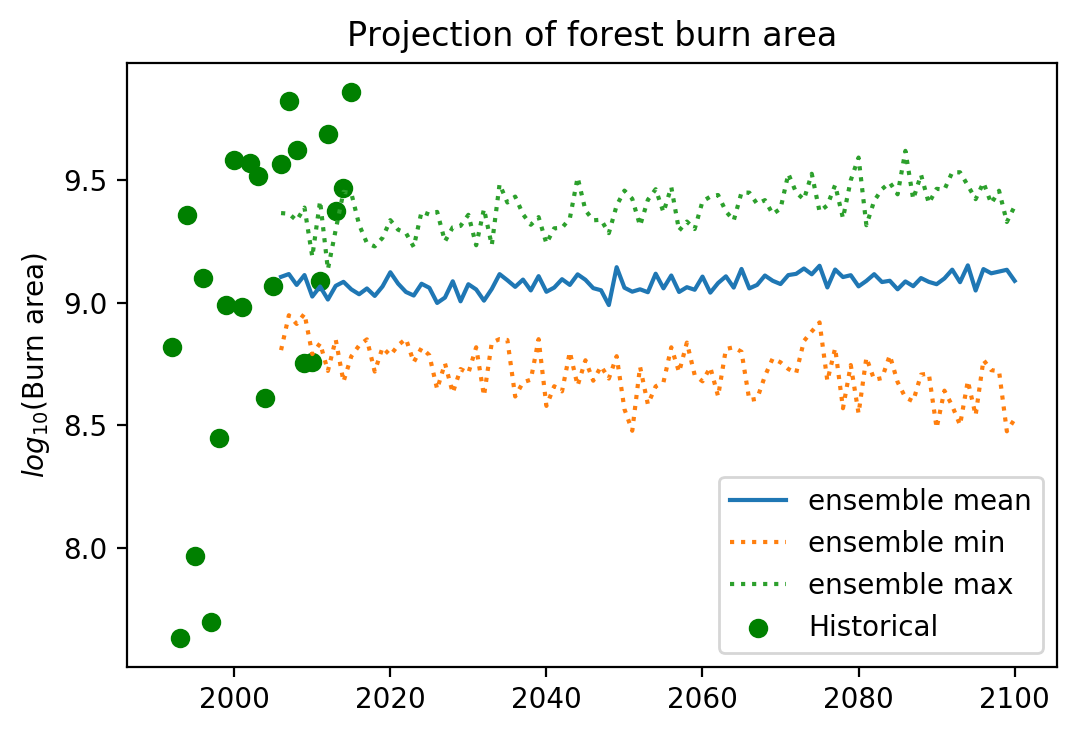

In [63]:
historical_BA = np.log10(df_targets['forest'].copy())

fig = plt.figure(dpi=200)
RCP_85_burn_areas["forest"].mean(axis=1).plot(label="ensemble mean")
RCP_85_burn_areas["forest"].min(axis=1).plot(label="ensemble min", linestyle=":")
RCP_85_burn_areas["forest"].max(axis=1).plot(label="ensemble max", linestyle=":")
plt.scatter(era_years, historical_BA, label="Historical", c="green")
plt.legend()
plt.ylabel("$log_{10}$(Burn area)")
plt.title("Projection of forest burn area")
plt.show()


#### What would this look like if it were OLS with temperature only? 
* Lets go ahead and call this a sanity check. 


In [48]:
BA_hist = np.log10(np.array(df_targets['forest'].copy()))
T_era = np.array(Z["t2m_summer"].copy())
T_era = T_era.reshape(-1, 1)
OLS = LinearRegression()
_=OLS.fit(T_era, BA_hist)

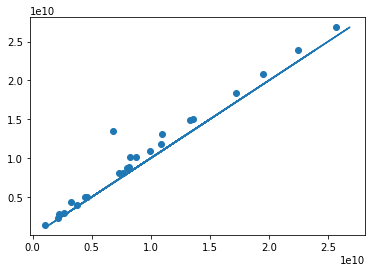

In [71]:
total = df_targets["forest"].values + df_targets["grass"].values + df_targets["shrubs"].values
plt.scatter(total, df_targets["all"])
plt.plot(df_targets["all"],df_targets["all"])

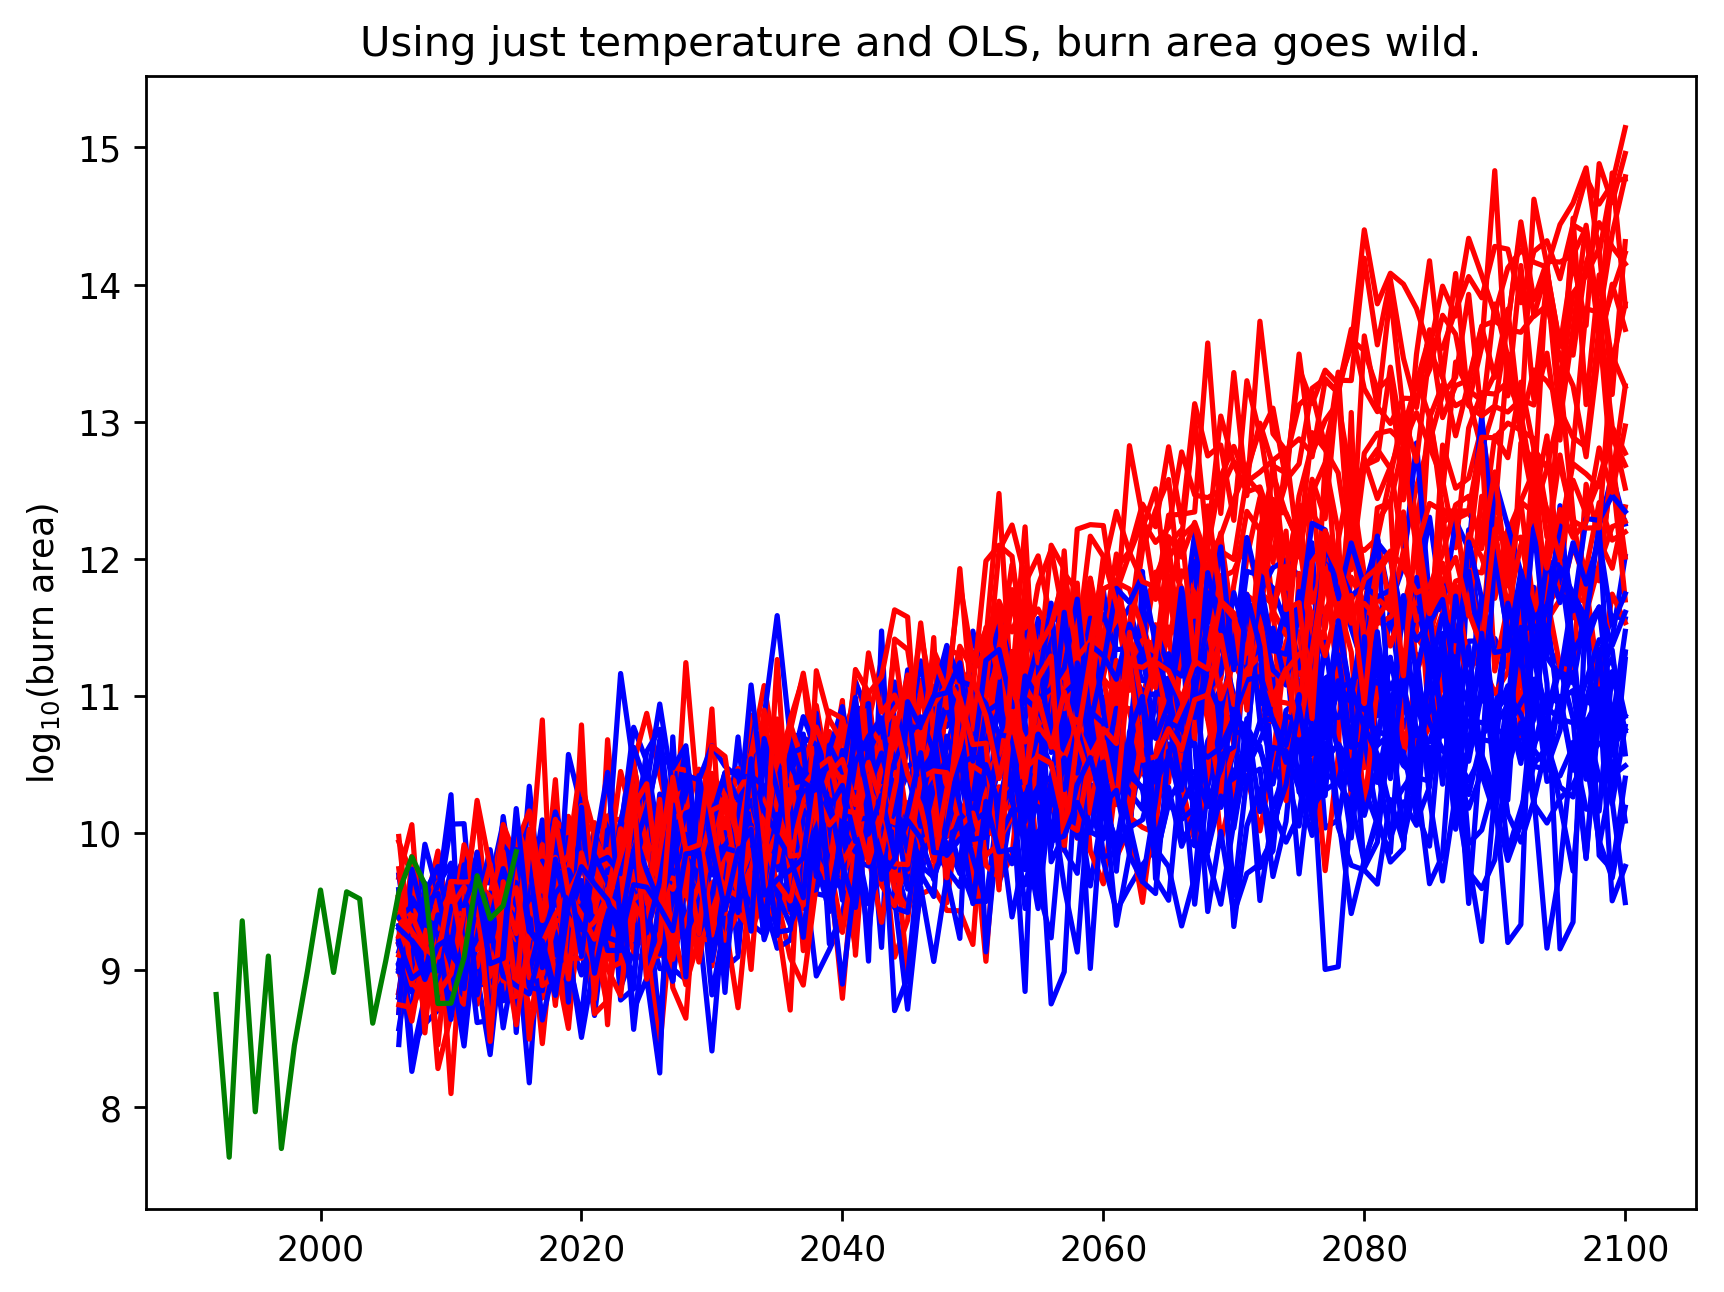

In [80]:
plt.figure(figsize=(10,6), dpi=250)
ax=plt.subplot(111)
for model in RCP_85_burn_areas["forest"].keys() :
    
    # 85 predictors 
    Z_future_feature = np.array(Z_futures85_dict[model]["t2m_summer"])
    Z_future_feature=Z_future_feature.reshape(-1,1)
    y_hat_85 = OLS.predict(Z_future_feature)
    plt.plot(cmip_years, y_hat_85, c="red")
    
    # 45 predictors 
    Z_future_feature = np.array(Z_futures45_dict[model]["t2m_summer"])
    Z_future_feature=Z_future_feature.reshape(-1,1)
    y_hat_45 = OLS.predict(Z_future_feature)
    plt.plot(cmip_years, y_hat_45, c="blue")
    
# Get the historical burn area on
plt.plot(era_years, BA_hist, c="green", label="Observed")
plt.ylabel("log$_{10}$(burn area)")
plt.title("Using just temperature and OLS, burn area goes wild.")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [74]:
RCP_85_burn_areas["forest"].keys()[0]

'ACCESS1-0'